# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact mlta-2022-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [1]:
!nvidia-smi

Tue May 17 06:49:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

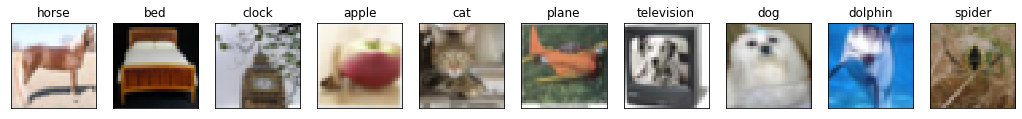

In [3]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

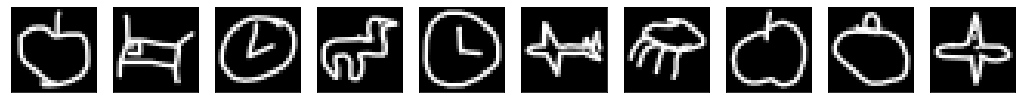

In [4]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


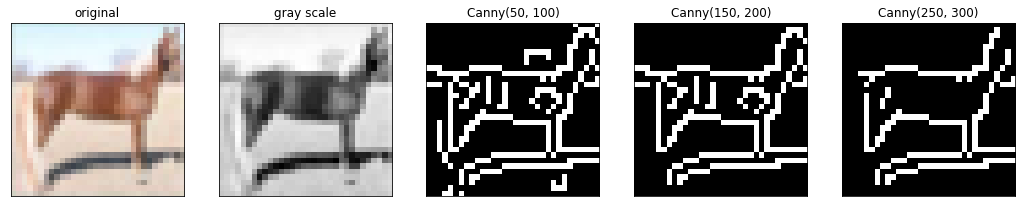

In [5]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [ ]:
!pip install transformers

In [7]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [17]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Hyper

In [18]:
num_epoch = 1000
tot_step = len(source_dataloader) * num_epoch
warm_up_step = (tot_step) / 10
lr = 1e-5

# Pre-processing

Here we use Adam as our optimizor.

In [19]:
import transformers

In [20]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.AdamW(feature_extractor.parameters(), lr=lr)
lr_scheduler_F = transformers.get_linear_schedule_with_warmup(optimizer_F, warm_up_step, tot_step, last_epoch=-1)
optimizer_C = optim.AdamW(label_predictor.parameters(), lr=lr)
lr_scheduler_C = transformers.get_linear_schedule_with_warmup(optimizer_C, warm_up_step, tot_step, last_epoch=-1)
optimizer_D = optim.AdamW(domain_classifier.parameters(), lr=lr)
lr_scheduler_D = transformers.get_linear_schedule_with_warmup(optimizer_D, warm_up_step, tot_step, last_epoch=-1)

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [21]:
def lamb_scheduler(epoch, tot_epoch=num_epoch, mx=2):
    return mx/(1+ math.exp(-10*((epoch+1)/tot_epoch))) - 1

In [22]:
from tqdm import tqdm
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    step = 0
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()
        lr_scheduler_D.step()
        lr_scheduler_F.step()
        lr_scheduler_C.step()
        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

for epoch in tqdm(range(num_epoch)):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=lamb_scheduler(epoch, num_epoch))

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:08<2:25:00,  8.71s/it]

epoch   0: train D loss: 0.7700, train F loss: 2.3004, acc 0.1006


  0%|          | 2/1000 [00:17<2:24:48,  8.71s/it]

epoch   1: train D loss: 0.7500, train F loss: 2.2935, acc 0.1030


  0%|          | 3/1000 [00:25<2:23:34,  8.64s/it]

epoch   2: train D loss: 0.7117, train F loss: 2.2815, acc 0.1174


  0%|          | 4/1000 [00:34<2:23:12,  8.63s/it]

epoch   3: train D loss: 0.6679, train F loss: 2.2704, acc 0.1238


  0%|          | 5/1000 [00:43<2:22:44,  8.61s/it]

epoch   4: train D loss: 0.6102, train F loss: 2.2548, acc 0.1492


  1%|          | 6/1000 [00:51<2:22:18,  8.59s/it]

epoch   5: train D loss: 0.5544, train F loss: 2.2383, acc 0.1850


  1%|          | 7/1000 [01:00<2:21:48,  8.57s/it]

epoch   6: train D loss: 0.4971, train F loss: 2.2181, acc 0.2150


  1%|          | 8/1000 [01:08<2:21:40,  8.57s/it]

epoch   7: train D loss: 0.4442, train F loss: 2.1954, acc 0.2366


  1%|          | 9/1000 [01:17<2:22:29,  8.63s/it]

epoch   8: train D loss: 0.3917, train F loss: 2.1694, acc 0.2522


  1%|          | 10/1000 [01:26<2:22:05,  8.61s/it]

epoch   9: train D loss: 0.3393, train F loss: 2.1357, acc 0.2782


  1%|          | 11/1000 [01:34<2:21:57,  8.61s/it]

epoch  10: train D loss: 0.2861, train F loss: 2.1012, acc 0.2890


  1%|          | 12/1000 [01:43<2:21:25,  8.59s/it]

epoch  11: train D loss: 0.2389, train F loss: 2.0586, acc 0.3018


  1%|▏         | 13/1000 [01:51<2:21:12,  8.58s/it]

epoch  12: train D loss: 0.1975, train F loss: 2.0207, acc 0.3016


  1%|▏         | 14/1000 [02:00<2:21:00,  8.58s/it]

epoch  13: train D loss: 0.1607, train F loss: 1.9798, acc 0.3148


  2%|▏         | 15/1000 [02:09<2:21:03,  8.59s/it]

epoch  14: train D loss: 0.1296, train F loss: 1.9426, acc 0.3254


  2%|▏         | 16/1000 [02:17<2:20:50,  8.59s/it]

epoch  15: train D loss: 0.1041, train F loss: 1.9014, acc 0.3492


  2%|▏         | 17/1000 [02:26<2:20:58,  8.60s/it]

epoch  16: train D loss: 0.0819, train F loss: 1.8633, acc 0.3610


  2%|▏         | 18/1000 [02:34<2:20:39,  8.59s/it]

epoch  17: train D loss: 0.0675, train F loss: 1.8146, acc 0.3816


  2%|▏         | 19/1000 [02:43<2:20:23,  8.59s/it]

epoch  18: train D loss: 0.0556, train F loss: 1.7734, acc 0.3958


  2%|▏         | 20/1000 [02:51<2:20:10,  8.58s/it]

epoch  19: train D loss: 0.0465, train F loss: 1.7254, acc 0.4126


  2%|▏         | 21/1000 [03:00<2:20:00,  8.58s/it]

epoch  20: train D loss: 0.0403, train F loss: 1.6812, acc 0.4250


  2%|▏         | 22/1000 [03:09<2:19:52,  8.58s/it]

epoch  21: train D loss: 0.0352, train F loss: 1.6383, acc 0.4412


  2%|▏         | 23/1000 [03:17<2:19:35,  8.57s/it]

epoch  22: train D loss: 0.0315, train F loss: 1.5975, acc 0.4600


  2%|▏         | 24/1000 [03:26<2:19:21,  8.57s/it]

epoch  23: train D loss: 0.0287, train F loss: 1.5562, acc 0.4674


  2%|▎         | 25/1000 [03:34<2:19:27,  8.58s/it]

epoch  24: train D loss: 0.0262, train F loss: 1.5282, acc 0.4768


  3%|▎         | 26/1000 [03:43<2:19:14,  8.58s/it]

epoch  25: train D loss: 0.0245, train F loss: 1.4907, acc 0.4822


  3%|▎         | 27/1000 [03:51<2:18:55,  8.57s/it]

epoch  26: train D loss: 0.0216, train F loss: 1.4617, acc 0.4886


  3%|▎         | 28/1000 [04:00<2:18:51,  8.57s/it]

epoch  27: train D loss: 0.0201, train F loss: 1.4445, acc 0.4960


  3%|▎         | 29/1000 [04:09<2:18:57,  8.59s/it]

epoch  28: train D loss: 0.0199, train F loss: 1.4277, acc 0.5042


  3%|▎         | 30/1000 [04:17<2:18:51,  8.59s/it]

epoch  29: train D loss: 0.0184, train F loss: 1.3867, acc 0.5210


  3%|▎         | 31/1000 [04:26<2:18:33,  8.58s/it]

epoch  30: train D loss: 0.0182, train F loss: 1.3786, acc 0.5242


  3%|▎         | 32/1000 [04:34<2:18:29,  8.58s/it]

epoch  31: train D loss: 0.0164, train F loss: 1.3593, acc 0.5332


  3%|▎         | 33/1000 [04:43<2:18:12,  8.58s/it]

epoch  32: train D loss: 0.0166, train F loss: 1.3342, acc 0.5460


  3%|▎         | 34/1000 [04:52<2:17:55,  8.57s/it]

epoch  33: train D loss: 0.0151, train F loss: 1.3296, acc 0.5372


  4%|▎         | 35/1000 [05:00<2:17:46,  8.57s/it]

epoch  34: train D loss: 0.0158, train F loss: 1.3115, acc 0.5516


  4%|▎         | 36/1000 [05:09<2:18:16,  8.61s/it]

epoch  35: train D loss: 0.0153, train F loss: 1.2965, acc 0.5498


  4%|▎         | 37/1000 [05:17<2:17:52,  8.59s/it]

epoch  36: train D loss: 0.0166, train F loss: 1.2822, acc 0.5558


  4%|▍         | 38/1000 [05:26<2:17:35,  8.58s/it]

epoch  37: train D loss: 0.0171, train F loss: 1.2549, acc 0.5680


  4%|▍         | 39/1000 [05:35<2:17:35,  8.59s/it]

epoch  38: train D loss: 0.0162, train F loss: 1.2409, acc 0.5656


  4%|▍         | 40/1000 [05:43<2:17:24,  8.59s/it]

epoch  39: train D loss: 0.0164, train F loss: 1.2260, acc 0.5824


  4%|▍         | 41/1000 [05:52<2:17:09,  8.58s/it]

epoch  40: train D loss: 0.0158, train F loss: 1.2241, acc 0.5812


  4%|▍         | 42/1000 [06:00<2:17:00,  8.58s/it]

epoch  41: train D loss: 0.0150, train F loss: 1.1978, acc 0.5932


  4%|▍         | 43/1000 [06:09<2:16:55,  8.59s/it]

epoch  42: train D loss: 0.0163, train F loss: 1.1851, acc 0.5886


  4%|▍         | 44/1000 [06:18<2:17:09,  8.61s/it]

epoch  43: train D loss: 0.0149, train F loss: 1.1576, acc 0.5984


  4%|▍         | 45/1000 [06:26<2:16:49,  8.60s/it]

epoch  44: train D loss: 0.0150, train F loss: 1.1425, acc 0.5996


  5%|▍         | 46/1000 [06:35<2:16:29,  8.58s/it]

epoch  45: train D loss: 0.0143, train F loss: 1.1294, acc 0.6110


  5%|▍         | 47/1000 [06:43<2:16:19,  8.58s/it]

epoch  46: train D loss: 0.0155, train F loss: 1.1155, acc 0.6188


  5%|▍         | 48/1000 [06:52<2:16:03,  8.57s/it]

epoch  47: train D loss: 0.0150, train F loss: 1.1020, acc 0.6192


  5%|▍         | 49/1000 [07:00<2:15:54,  8.57s/it]

epoch  48: train D loss: 0.0159, train F loss: 1.0829, acc 0.6276


  5%|▌         | 50/1000 [07:09<2:16:00,  8.59s/it]

epoch  49: train D loss: 0.0147, train F loss: 1.0713, acc 0.6298


  5%|▌         | 51/1000 [07:18<2:15:46,  8.58s/it]

epoch  50: train D loss: 0.0141, train F loss: 1.0398, acc 0.6446


  5%|▌         | 52/1000 [07:26<2:15:28,  8.57s/it]

epoch  51: train D loss: 0.0157, train F loss: 1.0226, acc 0.6478


  5%|▌         | 53/1000 [07:35<2:15:36,  8.59s/it]

epoch  52: train D loss: 0.0161, train F loss: 1.0226, acc 0.6536


  5%|▌         | 54/1000 [07:43<2:15:25,  8.59s/it]

epoch  53: train D loss: 0.0168, train F loss: 1.0009, acc 0.6610


  6%|▌         | 55/1000 [07:52<2:15:06,  8.58s/it]

epoch  54: train D loss: 0.0156, train F loss: 0.9888, acc 0.6656


  6%|▌         | 56/1000 [08:00<2:14:57,  8.58s/it]

epoch  55: train D loss: 0.0159, train F loss: 0.9822, acc 0.6642


  6%|▌         | 57/1000 [08:09<2:14:58,  8.59s/it]

epoch  56: train D loss: 0.0161, train F loss: 0.9577, acc 0.6714


  6%|▌         | 58/1000 [08:18<2:14:50,  8.59s/it]

epoch  57: train D loss: 0.0156, train F loss: 0.9480, acc 0.6794


  6%|▌         | 59/1000 [08:26<2:14:36,  8.58s/it]

epoch  58: train D loss: 0.0163, train F loss: 0.9142, acc 0.6924


  6%|▌         | 60/1000 [08:35<2:14:26,  8.58s/it]

epoch  59: train D loss: 0.0154, train F loss: 0.8903, acc 0.7002


  6%|▌         | 61/1000 [08:43<2:14:16,  8.58s/it]

epoch  60: train D loss: 0.0160, train F loss: 0.8827, acc 0.7024


  6%|▌         | 62/1000 [08:52<2:14:10,  8.58s/it]

epoch  61: train D loss: 0.0169, train F loss: 0.8514, acc 0.7142


  6%|▋         | 63/1000 [09:01<2:14:12,  8.59s/it]

epoch  62: train D loss: 0.0162, train F loss: 0.8462, acc 0.7150


  6%|▋         | 64/1000 [09:09<2:14:14,  8.61s/it]

epoch  63: train D loss: 0.0160, train F loss: 0.8252, acc 0.7222


  6%|▋         | 65/1000 [09:18<2:13:59,  8.60s/it]

epoch  64: train D loss: 0.0172, train F loss: 0.8167, acc 0.7296


  7%|▋         | 66/1000 [09:26<2:13:41,  8.59s/it]

epoch  65: train D loss: 0.0170, train F loss: 0.7879, acc 0.7338


  7%|▋         | 67/1000 [09:35<2:13:26,  8.58s/it]

epoch  66: train D loss: 0.0169, train F loss: 0.7728, acc 0.7344


  7%|▋         | 68/1000 [09:43<2:13:19,  8.58s/it]

epoch  67: train D loss: 0.0172, train F loss: 0.7324, acc 0.7566


  7%|▋         | 69/1000 [09:52<2:13:08,  8.58s/it]

epoch  68: train D loss: 0.0172, train F loss: 0.7265, acc 0.7572


  7%|▋         | 70/1000 [10:01<2:12:59,  8.58s/it]

epoch  69: train D loss: 0.0165, train F loss: 0.6969, acc 0.7692


  7%|▋         | 71/1000 [10:09<2:13:08,  8.60s/it]

epoch  70: train D loss: 0.0181, train F loss: 0.6927, acc 0.7684


  7%|▋         | 72/1000 [10:18<2:13:07,  8.61s/it]

epoch  71: train D loss: 0.0182, train F loss: 0.6779, acc 0.7762


  7%|▋         | 73/1000 [10:27<2:13:06,  8.62s/it]

epoch  72: train D loss: 0.0175, train F loss: 0.6529, acc 0.7826


  7%|▋         | 74/1000 [10:35<2:12:50,  8.61s/it]

epoch  73: train D loss: 0.0181, train F loss: 0.6218, acc 0.7962


  8%|▊         | 75/1000 [10:44<2:12:39,  8.60s/it]

epoch  74: train D loss: 0.0191, train F loss: 0.6032, acc 0.7994


  8%|▊         | 76/1000 [10:52<2:12:25,  8.60s/it]

epoch  75: train D loss: 0.0210, train F loss: 0.5993, acc 0.7976


  8%|▊         | 77/1000 [11:01<2:12:09,  8.59s/it]

epoch  76: train D loss: 0.0246, train F loss: 0.5711, acc 0.8060


  8%|▊         | 78/1000 [11:10<2:12:08,  8.60s/it]

epoch  77: train D loss: 0.0253, train F loss: 0.5710, acc 0.8078


  8%|▊         | 79/1000 [11:18<2:12:36,  8.64s/it]

epoch  78: train D loss: 0.0247, train F loss: 0.5367, acc 0.8220


  8%|▊         | 80/1000 [11:27<2:12:10,  8.62s/it]

epoch  79: train D loss: 0.0264, train F loss: 0.5218, acc 0.8300


  8%|▊         | 81/1000 [11:35<2:12:11,  8.63s/it]

epoch  80: train D loss: 0.0293, train F loss: 0.5000, acc 0.8326


  8%|▊         | 82/1000 [11:44<2:11:41,  8.61s/it]

epoch  81: train D loss: 0.0316, train F loss: 0.5134, acc 0.8270


  8%|▊         | 83/1000 [11:53<2:11:21,  8.59s/it]

epoch  82: train D loss: 0.0364, train F loss: 0.4888, acc 0.8360


  8%|▊         | 84/1000 [12:01<2:11:16,  8.60s/it]

epoch  83: train D loss: 0.0614, train F loss: 0.4575, acc 0.8436


  8%|▊         | 85/1000 [12:10<2:11:21,  8.61s/it]

epoch  84: train D loss: 0.5488, train F loss: 0.3615, acc 0.8410


  9%|▊         | 86/1000 [12:18<2:11:00,  8.60s/it]

epoch  85: train D loss: 0.8004, train F loss: 0.3219, acc 0.8272


  9%|▊         | 87/1000 [12:27<2:10:47,  8.60s/it]

epoch  86: train D loss: 0.9062, train F loss: 0.2517, acc 0.8274


  9%|▉         | 88/1000 [12:36<2:10:30,  8.59s/it]

epoch  87: train D loss: 0.8964, train F loss: 0.2043, acc 0.8338


  9%|▉         | 89/1000 [12:44<2:10:36,  8.60s/it]

epoch  88: train D loss: 0.8730, train F loss: 0.1637, acc 0.8408


  9%|▉         | 90/1000 [12:53<2:10:29,  8.60s/it]

epoch  89: train D loss: 0.7952, train F loss: 0.1528, acc 0.8592


  9%|▉         | 91/1000 [13:01<2:10:19,  8.60s/it]

epoch  90: train D loss: 0.7740, train F loss: 0.1510, acc 0.8558


  9%|▉         | 92/1000 [13:10<2:10:13,  8.60s/it]

epoch  91: train D loss: 0.7648, train F loss: 0.1467, acc 0.8528


  9%|▉         | 93/1000 [13:19<2:10:02,  8.60s/it]

epoch  92: train D loss: 0.7693, train F loss: 0.1127, acc 0.8586


  9%|▉         | 94/1000 [13:27<2:09:46,  8.59s/it]

epoch  93: train D loss: 0.7527, train F loss: 0.0890, acc 0.8702


 10%|▉         | 95/1000 [13:36<2:09:38,  8.60s/it]

epoch  94: train D loss: 0.7298, train F loss: 0.0859, acc 0.8732


 10%|▉         | 96/1000 [13:44<2:09:31,  8.60s/it]

epoch  95: train D loss: 0.7461, train F loss: 0.0693, acc 0.8738


 10%|▉         | 97/1000 [13:53<2:09:14,  8.59s/it]

epoch  96: train D loss: 0.7495, train F loss: 0.0430, acc 0.8844


 10%|▉         | 98/1000 [14:02<2:09:05,  8.59s/it]

epoch  97: train D loss: 0.7261, train F loss: 0.0384, acc 0.8818


 10%|▉         | 99/1000 [14:10<2:09:06,  8.60s/it]

epoch  98: train D loss: 0.7297, train F loss: 0.0172, acc 0.8862


 10%|█         | 100/1000 [14:19<2:08:52,  8.59s/it]

epoch  99: train D loss: 0.6946, train F loss: 0.0194, acc 0.8972


 10%|█         | 101/1000 [14:27<2:08:34,  8.58s/it]

epoch 100: train D loss: 0.7245, train F loss: -0.0042, acc 0.8994


 10%|█         | 102/1000 [14:36<2:08:29,  8.58s/it]

epoch 101: train D loss: 0.7211, train F loss: -0.0401, acc 0.9086


 10%|█         | 103/1000 [14:45<2:08:24,  8.59s/it]

epoch 102: train D loss: 0.7101, train F loss: -0.0423, acc 0.9070


 10%|█         | 104/1000 [14:53<2:08:11,  8.58s/it]

epoch 103: train D loss: 0.6957, train F loss: -0.0423, acc 0.9112


 10%|█         | 105/1000 [15:02<2:08:05,  8.59s/it]

epoch 104: train D loss: 0.7148, train F loss: -0.0554, acc 0.9098


 11%|█         | 106/1000 [15:10<2:08:17,  8.61s/it]

epoch 105: train D loss: 0.6910, train F loss: -0.0545, acc 0.9106


 11%|█         | 107/1000 [15:19<2:07:52,  8.59s/it]

epoch 106: train D loss: 0.7187, train F loss: -0.0791, acc 0.9172


 11%|█         | 108/1000 [15:27<2:07:49,  8.60s/it]

epoch 107: train D loss: 0.7130, train F loss: -0.0948, acc 0.9182


 11%|█         | 109/1000 [15:36<2:07:33,  8.59s/it]

epoch 108: train D loss: 0.6946, train F loss: -0.0837, acc 0.9184


 11%|█         | 110/1000 [15:45<2:07:17,  8.58s/it]

epoch 109: train D loss: 0.7089, train F loss: -0.1236, acc 0.9304


 11%|█         | 111/1000 [15:53<2:07:06,  8.58s/it]

epoch 110: train D loss: 0.6953, train F loss: -0.0904, acc 0.9184


 11%|█         | 112/1000 [16:02<2:06:57,  8.58s/it]

epoch 111: train D loss: 0.7136, train F loss: -0.1353, acc 0.9306


 11%|█▏        | 113/1000 [16:10<2:07:09,  8.60s/it]

epoch 112: train D loss: 0.6833, train F loss: -0.1142, acc 0.9234


 11%|█▏        | 114/1000 [16:19<2:07:34,  8.64s/it]

epoch 113: train D loss: 0.7052, train F loss: -0.1407, acc 0.9316


 12%|█▏        | 115/1000 [16:28<2:07:11,  8.62s/it]

epoch 114: train D loss: 0.6942, train F loss: -0.1447, acc 0.9336


 12%|█▏        | 116/1000 [16:36<2:06:56,  8.62s/it]

epoch 115: train D loss: 0.6920, train F loss: -0.1639, acc 0.9390


 12%|█▏        | 117/1000 [16:45<2:06:44,  8.61s/it]

epoch 116: train D loss: 0.7051, train F loss: -0.1838, acc 0.9390


 12%|█▏        | 118/1000 [16:54<2:06:20,  8.60s/it]

epoch 117: train D loss: 0.6905, train F loss: -0.1624, acc 0.9368


 12%|█▏        | 119/1000 [17:02<2:05:54,  8.57s/it]

epoch 118: train D loss: 0.7037, train F loss: -0.1865, acc 0.9468


 12%|█▏        | 120/1000 [17:11<2:05:48,  8.58s/it]

epoch 119: train D loss: 0.6963, train F loss: -0.1917, acc 0.9430


 12%|█▏        | 121/1000 [17:19<2:05:53,  8.59s/it]

epoch 120: train D loss: 0.6931, train F loss: -0.1922, acc 0.9426


 12%|█▏        | 122/1000 [17:28<2:05:33,  8.58s/it]

epoch 121: train D loss: 0.7205, train F loss: -0.2014, acc 0.9430


 12%|█▏        | 123/1000 [17:36<2:05:16,  8.57s/it]

epoch 122: train D loss: 0.6898, train F loss: -0.2016, acc 0.9452


 12%|█▏        | 124/1000 [17:45<2:05:19,  8.58s/it]

epoch 123: train D loss: 0.7112, train F loss: -0.2240, acc 0.9460


 12%|█▎        | 125/1000 [17:54<2:05:17,  8.59s/it]

epoch 124: train D loss: 0.6885, train F loss: -0.2100, acc 0.9466


 13%|█▎        | 126/1000 [18:02<2:05:10,  8.59s/it]

epoch 125: train D loss: 0.7000, train F loss: -0.2231, acc 0.9494


 13%|█▎        | 127/1000 [18:11<2:05:02,  8.59s/it]

epoch 126: train D loss: 0.6970, train F loss: -0.2121, acc 0.9478


 13%|█▎        | 128/1000 [18:19<2:04:46,  8.59s/it]

epoch 127: train D loss: 0.7020, train F loss: -0.2288, acc 0.9440


 13%|█▎        | 129/1000 [18:28<2:04:32,  8.58s/it]

epoch 128: train D loss: 0.7025, train F loss: -0.2509, acc 0.9558


 13%|█▎        | 130/1000 [18:36<2:04:30,  8.59s/it]

epoch 129: train D loss: 0.7008, train F loss: -0.2517, acc 0.9520


 13%|█▎        | 131/1000 [18:45<2:04:20,  8.59s/it]

epoch 130: train D loss: 0.7048, train F loss: -0.2541, acc 0.9548


 13%|█▎        | 132/1000 [18:54<2:04:03,  8.58s/it]

epoch 131: train D loss: 0.6946, train F loss: -0.2640, acc 0.9596


 13%|█▎        | 133/1000 [19:02<2:03:54,  8.58s/it]

epoch 132: train D loss: 0.6910, train F loss: -0.2511, acc 0.9494


 13%|█▎        | 134/1000 [19:11<2:04:03,  8.60s/it]

epoch 133: train D loss: 0.7142, train F loss: -0.2751, acc 0.9614


 14%|█▎        | 135/1000 [19:19<2:04:02,  8.60s/it]

epoch 134: train D loss: 0.6849, train F loss: -0.2488, acc 0.9516


 14%|█▎        | 136/1000 [19:28<2:03:42,  8.59s/it]

epoch 135: train D loss: 0.7082, train F loss: -0.2987, acc 0.9622


 14%|█▎        | 137/1000 [19:37<2:03:26,  8.58s/it]

epoch 136: train D loss: 0.6863, train F loss: -0.2885, acc 0.9640


 14%|█▍        | 138/1000 [19:45<2:03:15,  8.58s/it]

epoch 137: train D loss: 0.6890, train F loss: -0.2432, acc 0.9486


 14%|█▍        | 139/1000 [19:54<2:03:13,  8.59s/it]

epoch 138: train D loss: 0.7115, train F loss: -0.3019, acc 0.9594


 14%|█▍        | 140/1000 [20:02<2:02:55,  8.58s/it]

epoch 139: train D loss: 0.6852, train F loss: -0.2976, acc 0.9626


 14%|█▍        | 141/1000 [20:11<2:03:21,  8.62s/it]

epoch 140: train D loss: 0.7020, train F loss: -0.3121, acc 0.9674


 14%|█▍        | 142/1000 [20:20<2:03:13,  8.62s/it]

epoch 141: train D loss: 0.6801, train F loss: -0.2881, acc 0.9606


 14%|█▍        | 143/1000 [20:28<2:03:11,  8.62s/it]

epoch 142: train D loss: 0.7095, train F loss: -0.3072, acc 0.9594


 14%|█▍        | 144/1000 [20:37<2:03:04,  8.63s/it]

epoch 143: train D loss: 0.6982, train F loss: -0.3324, acc 0.9724


 14%|█▍        | 145/1000 [20:45<2:02:39,  8.61s/it]

epoch 144: train D loss: 0.6782, train F loss: -0.3063, acc 0.9658


 15%|█▍        | 146/1000 [20:54<2:02:20,  8.60s/it]

epoch 145: train D loss: 0.7108, train F loss: -0.3297, acc 0.9648


 15%|█▍        | 147/1000 [21:03<2:02:21,  8.61s/it]

epoch 146: train D loss: 0.6968, train F loss: -0.3101, acc 0.9582


 15%|█▍        | 148/1000 [21:11<2:02:50,  8.65s/it]

epoch 147: train D loss: 0.6830, train F loss: -0.3094, acc 0.9604


 15%|█▍        | 149/1000 [21:20<2:02:35,  8.64s/it]

epoch 148: train D loss: 0.7010, train F loss: -0.3260, acc 0.9608


 15%|█▌        | 150/1000 [21:29<2:02:07,  8.62s/it]

epoch 149: train D loss: 0.7012, train F loss: -0.3285, acc 0.9612


 15%|█▌        | 151/1000 [21:37<2:01:55,  8.62s/it]

epoch 150: train D loss: 0.7018, train F loss: -0.3425, acc 0.9656


 15%|█▌        | 152/1000 [21:46<2:01:43,  8.61s/it]

epoch 151: train D loss: 0.7020, train F loss: -0.3402, acc 0.9654


 15%|█▌        | 153/1000 [21:54<2:01:32,  8.61s/it]

epoch 152: train D loss: 0.6946, train F loss: -0.3475, acc 0.9696


 15%|█▌        | 154/1000 [22:03<2:01:29,  8.62s/it]

epoch 153: train D loss: 0.7007, train F loss: -0.3401, acc 0.9682


 16%|█▌        | 155/1000 [22:12<2:01:12,  8.61s/it]

epoch 154: train D loss: 0.6935, train F loss: -0.3635, acc 0.9738


 16%|█▌        | 156/1000 [22:20<2:00:47,  8.59s/it]

epoch 155: train D loss: 0.6882, train F loss: -0.3573, acc 0.9692


 16%|█▌        | 157/1000 [22:29<2:00:31,  8.58s/it]

epoch 156: train D loss: 0.6861, train F loss: -0.3599, acc 0.9708


 16%|█▌        | 158/1000 [22:37<2:00:21,  8.58s/it]

epoch 157: train D loss: 0.6892, train F loss: -0.3650, acc 0.9710


 16%|█▌        | 159/1000 [22:46<2:00:09,  8.57s/it]

epoch 158: train D loss: 0.6910, train F loss: -0.3780, acc 0.9760


 16%|█▌        | 160/1000 [22:54<2:00:02,  8.57s/it]

epoch 159: train D loss: 0.6928, train F loss: -0.3661, acc 0.9706


 16%|█▌        | 161/1000 [23:03<2:00:14,  8.60s/it]

epoch 160: train D loss: 0.6938, train F loss: -0.3651, acc 0.9722


 16%|█▌        | 162/1000 [23:12<2:00:24,  8.62s/it]

epoch 161: train D loss: 0.6866, train F loss: -0.3518, acc 0.9656


 16%|█▋        | 163/1000 [23:20<2:00:13,  8.62s/it]

epoch 162: train D loss: 0.6991, train F loss: -0.3577, acc 0.9644


 16%|█▋        | 164/1000 [23:29<1:59:52,  8.60s/it]

epoch 163: train D loss: 0.6837, train F loss: -0.3683, acc 0.9712


 16%|█▋        | 165/1000 [23:38<1:59:46,  8.61s/it]

epoch 164: train D loss: 0.6883, train F loss: -0.3846, acc 0.9744


 17%|█▋        | 166/1000 [23:46<1:59:25,  8.59s/it]

epoch 165: train D loss: 0.6849, train F loss: -0.3860, acc 0.9782


 17%|█▋        | 167/1000 [23:55<1:59:16,  8.59s/it]

epoch 166: train D loss: 0.6956, train F loss: -0.3909, acc 0.9736


 17%|█▋        | 168/1000 [24:03<1:58:59,  8.58s/it]

epoch 167: train D loss: 0.6863, train F loss: -0.3846, acc 0.9728


 17%|█▋        | 169/1000 [24:12<1:59:13,  8.61s/it]

epoch 168: train D loss: 0.6980, train F loss: -0.3927, acc 0.9722


 17%|█▋        | 170/1000 [24:21<1:59:06,  8.61s/it]

epoch 169: train D loss: 0.6918, train F loss: -0.3957, acc 0.9766


 17%|█▋        | 171/1000 [24:29<1:58:49,  8.60s/it]

epoch 170: train D loss: 0.6886, train F loss: -0.3884, acc 0.9730


 17%|█▋        | 172/1000 [24:38<1:58:47,  8.61s/it]

epoch 171: train D loss: 0.6925, train F loss: -0.3974, acc 0.9736


 17%|█▋        | 173/1000 [24:46<1:58:30,  8.60s/it]

epoch 172: train D loss: 0.6885, train F loss: -0.3909, acc 0.9704


 17%|█▋        | 174/1000 [24:55<1:58:18,  8.59s/it]

epoch 173: train D loss: 0.6943, train F loss: -0.4121, acc 0.9782


 18%|█▊        | 175/1000 [25:04<1:58:09,  8.59s/it]

epoch 174: train D loss: 0.6929, train F loss: -0.4081, acc 0.9746


 18%|█▊        | 176/1000 [25:12<1:58:19,  8.62s/it]

epoch 175: train D loss: 0.6853, train F loss: -0.4112, acc 0.9748


 18%|█▊        | 177/1000 [25:21<1:58:02,  8.61s/it]

epoch 176: train D loss: 0.6815, train F loss: -0.3999, acc 0.9724


 18%|█▊        | 178/1000 [25:29<1:57:35,  8.58s/it]

epoch 177: train D loss: 0.6906, train F loss: -0.4153, acc 0.9762


 18%|█▊        | 179/1000 [25:38<1:57:18,  8.57s/it]

epoch 178: train D loss: 0.6895, train F loss: -0.4073, acc 0.9730


 18%|█▊        | 180/1000 [25:46<1:57:21,  8.59s/it]

epoch 179: train D loss: 0.6807, train F loss: -0.4153, acc 0.9768


 18%|█▊        | 181/1000 [25:55<1:57:05,  8.58s/it]

epoch 180: train D loss: 0.6978, train F loss: -0.4201, acc 0.9732


 18%|█▊        | 182/1000 [26:04<1:57:10,  8.60s/it]

epoch 181: train D loss: 0.6830, train F loss: -0.4174, acc 0.9764


 18%|█▊        | 183/1000 [26:12<1:57:37,  8.64s/it]

epoch 182: train D loss: 0.6863, train F loss: -0.4105, acc 0.9718


 18%|█▊        | 184/1000 [26:21<1:57:11,  8.62s/it]

epoch 183: train D loss: 0.6854, train F loss: -0.4287, acc 0.9784


 18%|█▊        | 185/1000 [26:30<1:56:55,  8.61s/it]

epoch 184: train D loss: 0.6825, train F loss: -0.4316, acc 0.9806


 19%|█▊        | 186/1000 [26:38<1:56:39,  8.60s/it]

epoch 185: train D loss: 0.6914, train F loss: -0.4234, acc 0.9718


 19%|█▊        | 187/1000 [26:47<1:56:50,  8.62s/it]

epoch 186: train D loss: 0.6865, train F loss: -0.4264, acc 0.9746


 19%|█▉        | 188/1000 [26:55<1:56:28,  8.61s/it]

epoch 187: train D loss: 0.6891, train F loss: -0.4327, acc 0.9766


 19%|█▉        | 189/1000 [27:04<1:56:22,  8.61s/it]

epoch 188: train D loss: 0.6796, train F loss: -0.4203, acc 0.9740


 19%|█▉        | 190/1000 [27:13<1:56:18,  8.62s/it]

epoch 189: train D loss: 0.6866, train F loss: -0.4343, acc 0.9768


 19%|█▉        | 191/1000 [27:21<1:56:00,  8.60s/it]

epoch 190: train D loss: 0.6810, train F loss: -0.4211, acc 0.9702


 19%|█▉        | 192/1000 [27:30<1:55:42,  8.59s/it]

epoch 191: train D loss: 0.6820, train F loss: -0.4154, acc 0.9710


 19%|█▉        | 193/1000 [27:38<1:55:28,  8.59s/it]

epoch 192: train D loss: 0.6788, train F loss: -0.4375, acc 0.9780


 19%|█▉        | 194/1000 [27:47<1:55:29,  8.60s/it]

epoch 193: train D loss: 0.6861, train F loss: -0.4487, acc 0.9798


 20%|█▉        | 195/1000 [27:56<1:55:11,  8.59s/it]

epoch 194: train D loss: 0.6734, train F loss: -0.4301, acc 0.9752


 20%|█▉        | 196/1000 [28:04<1:54:54,  8.57s/it]

epoch 195: train D loss: 0.6888, train F loss: -0.4374, acc 0.9736


 20%|█▉        | 197/1000 [28:13<1:55:06,  8.60s/it]

epoch 196: train D loss: 0.6851, train F loss: -0.4298, acc 0.9724


 20%|█▉        | 198/1000 [28:21<1:55:08,  8.61s/it]

epoch 197: train D loss: 0.6798, train F loss: -0.4390, acc 0.9786


 20%|█▉        | 199/1000 [28:30<1:54:55,  8.61s/it]

epoch 198: train D loss: 0.6813, train F loss: -0.4460, acc 0.9772


 20%|██        | 200/1000 [28:39<1:54:41,  8.60s/it]

epoch 199: train D loss: 0.6892, train F loss: -0.4646, acc 0.9822


 20%|██        | 201/1000 [28:47<1:54:29,  8.60s/it]

epoch 200: train D loss: 0.6765, train F loss: -0.4278, acc 0.9728


 20%|██        | 202/1000 [28:56<1:54:09,  8.58s/it]

epoch 201: train D loss: 0.6870, train F loss: -0.4608, acc 0.9808


 20%|██        | 203/1000 [29:04<1:53:57,  8.58s/it]

epoch 202: train D loss: 0.6831, train F loss: -0.4421, acc 0.9734


 20%|██        | 204/1000 [29:13<1:54:01,  8.60s/it]

epoch 203: train D loss: 0.6846, train F loss: -0.4571, acc 0.9796


 20%|██        | 205/1000 [29:22<1:53:49,  8.59s/it]

epoch 204: train D loss: 0.6845, train F loss: -0.4545, acc 0.9762


 21%|██        | 206/1000 [29:30<1:53:34,  8.58s/it]

epoch 205: train D loss: 0.6818, train F loss: -0.4692, acc 0.9806


 21%|██        | 207/1000 [29:39<1:53:25,  8.58s/it]

epoch 206: train D loss: 0.6778, train F loss: -0.4775, acc 0.9840


 21%|██        | 208/1000 [29:47<1:53:20,  8.59s/it]

epoch 207: train D loss: 0.6783, train F loss: -0.4730, acc 0.9838


 21%|██        | 209/1000 [29:56<1:53:14,  8.59s/it]

epoch 208: train D loss: 0.6851, train F loss: -0.4736, acc 0.9810


 21%|██        | 210/1000 [30:04<1:52:59,  8.58s/it]

epoch 209: train D loss: 0.6871, train F loss: -0.4739, acc 0.9778


 21%|██        | 211/1000 [30:13<1:53:01,  8.59s/it]

epoch 210: train D loss: 0.6818, train F loss: -0.4656, acc 0.9784


 21%|██        | 212/1000 [30:22<1:52:49,  8.59s/it]

epoch 211: train D loss: 0.6876, train F loss: -0.4758, acc 0.9792


 21%|██▏       | 213/1000 [30:30<1:52:29,  8.58s/it]

epoch 212: train D loss: 0.6830, train F loss: -0.4648, acc 0.9750


 21%|██▏       | 214/1000 [30:39<1:52:27,  8.58s/it]

epoch 213: train D loss: 0.6823, train F loss: -0.4547, acc 0.9714


 22%|██▏       | 215/1000 [30:47<1:52:12,  8.58s/it]

epoch 214: train D loss: 0.6763, train F loss: -0.4608, acc 0.9736


 22%|██▏       | 216/1000 [30:56<1:52:00,  8.57s/it]

epoch 215: train D loss: 0.6812, train F loss: -0.4859, acc 0.9852


 22%|██▏       | 217/1000 [31:04<1:52:01,  8.58s/it]

epoch 216: train D loss: 0.6823, train F loss: -0.4791, acc 0.9804


 22%|██▏       | 218/1000 [31:13<1:52:42,  8.65s/it]

epoch 217: train D loss: 0.6742, train F loss: -0.4744, acc 0.9796


 22%|██▏       | 219/1000 [31:22<1:52:11,  8.62s/it]

epoch 218: train D loss: 0.6884, train F loss: -0.4874, acc 0.9792


 22%|██▏       | 220/1000 [31:30<1:51:47,  8.60s/it]

epoch 219: train D loss: 0.6768, train F loss: -0.4793, acc 0.9820


 22%|██▏       | 221/1000 [31:39<1:51:31,  8.59s/it]

epoch 220: train D loss: 0.6843, train F loss: -0.4741, acc 0.9728


 22%|██▏       | 222/1000 [31:48<1:51:16,  8.58s/it]

epoch 221: train D loss: 0.6895, train F loss: -0.4886, acc 0.9800


 22%|██▏       | 223/1000 [31:56<1:51:05,  8.58s/it]

epoch 222: train D loss: 0.6799, train F loss: -0.4835, acc 0.9786


 22%|██▏       | 224/1000 [32:05<1:51:11,  8.60s/it]

epoch 223: train D loss: 0.6809, train F loss: -0.4881, acc 0.9794


 22%|██▎       | 225/1000 [32:13<1:51:02,  8.60s/it]

epoch 224: train D loss: 0.6850, train F loss: -0.4903, acc 0.9766


 23%|██▎       | 226/1000 [32:22<1:50:44,  8.58s/it]

epoch 225: train D loss: 0.6798, train F loss: -0.4893, acc 0.9810


 23%|██▎       | 227/1000 [32:30<1:50:34,  8.58s/it]

epoch 226: train D loss: 0.6841, train F loss: -0.4678, acc 0.9720


 23%|██▎       | 228/1000 [32:39<1:50:28,  8.59s/it]

epoch 227: train D loss: 0.6802, train F loss: -0.4757, acc 0.9750


 23%|██▎       | 229/1000 [32:48<1:50:30,  8.60s/it]

epoch 228: train D loss: 0.6805, train F loss: -0.4974, acc 0.9810


 23%|██▎       | 230/1000 [32:56<1:50:23,  8.60s/it]

epoch 229: train D loss: 0.6754, train F loss: -0.4961, acc 0.9808


 23%|██▎       | 231/1000 [33:05<1:50:21,  8.61s/it]

epoch 230: train D loss: 0.6824, train F loss: -0.4957, acc 0.9806


 23%|██▎       | 232/1000 [33:14<1:50:12,  8.61s/it]

epoch 231: train D loss: 0.6881, train F loss: -0.5105, acc 0.9820


 23%|██▎       | 233/1000 [33:22<1:49:59,  8.60s/it]

epoch 232: train D loss: 0.6801, train F loss: -0.5020, acc 0.9822


 23%|██▎       | 234/1000 [33:31<1:49:53,  8.61s/it]

epoch 233: train D loss: 0.6810, train F loss: -0.5109, acc 0.9830


 24%|██▎       | 235/1000 [33:39<1:49:44,  8.61s/it]

epoch 234: train D loss: 0.6826, train F loss: -0.5115, acc 0.9836


 24%|██▎       | 236/1000 [33:48<1:49:21,  8.59s/it]

epoch 235: train D loss: 0.6831, train F loss: -0.5104, acc 0.9822


 24%|██▎       | 237/1000 [33:56<1:49:08,  8.58s/it]

epoch 236: train D loss: 0.6751, train F loss: -0.5089, acc 0.9836


 24%|██▍       | 238/1000 [34:05<1:49:08,  8.59s/it]

epoch 237: train D loss: 0.6831, train F loss: -0.5089, acc 0.9806


 24%|██▍       | 239/1000 [34:14<1:49:07,  8.60s/it]

epoch 238: train D loss: 0.6893, train F loss: -0.5066, acc 0.9790


 24%|██▍       | 240/1000 [34:22<1:48:56,  8.60s/it]

epoch 239: train D loss: 0.6788, train F loss: -0.4984, acc 0.9786


 24%|██▍       | 241/1000 [34:31<1:48:41,  8.59s/it]

epoch 240: train D loss: 0.6817, train F loss: -0.4999, acc 0.9792


 24%|██▍       | 242/1000 [34:39<1:48:30,  8.59s/it]

epoch 241: train D loss: 0.6835, train F loss: -0.5071, acc 0.9812


 24%|██▍       | 243/1000 [34:48<1:48:25,  8.59s/it]

epoch 242: train D loss: 0.6854, train F loss: -0.5213, acc 0.9836


 24%|██▍       | 244/1000 [34:57<1:48:24,  8.60s/it]

epoch 243: train D loss: 0.6851, train F loss: -0.5124, acc 0.9812


 24%|██▍       | 245/1000 [35:05<1:48:32,  8.63s/it]

epoch 244: train D loss: 0.6779, train F loss: -0.5211, acc 0.9840


 25%|██▍       | 246/1000 [35:14<1:48:18,  8.62s/it]

epoch 245: train D loss: 0.6832, train F loss: -0.5138, acc 0.9800


 25%|██▍       | 247/1000 [35:23<1:47:58,  8.60s/it]

epoch 246: train D loss: 0.6803, train F loss: -0.5083, acc 0.9778


 25%|██▍       | 248/1000 [35:31<1:47:46,  8.60s/it]

epoch 247: train D loss: 0.6859, train F loss: -0.5178, acc 0.9788


 25%|██▍       | 249/1000 [35:40<1:47:35,  8.60s/it]

epoch 248: train D loss: 0.6798, train F loss: -0.5177, acc 0.9822


 25%|██▌       | 250/1000 [35:48<1:47:39,  8.61s/it]

epoch 249: train D loss: 0.6766, train F loss: -0.5184, acc 0.9812


 25%|██▌       | 251/1000 [35:57<1:47:26,  8.61s/it]

epoch 250: train D loss: 0.6795, train F loss: -0.5177, acc 0.9808


 25%|██▌       | 252/1000 [36:06<1:47:17,  8.61s/it]

epoch 251: train D loss: 0.6828, train F loss: -0.5139, acc 0.9764


 25%|██▌       | 253/1000 [36:14<1:47:40,  8.65s/it]

epoch 252: train D loss: 0.6782, train F loss: -0.5200, acc 0.9806


 25%|██▌       | 254/1000 [36:23<1:47:14,  8.63s/it]

epoch 253: train D loss: 0.6869, train F loss: -0.5321, acc 0.9822


 26%|██▌       | 255/1000 [36:31<1:46:57,  8.61s/it]

epoch 254: train D loss: 0.6740, train F loss: -0.5232, acc 0.9822


 26%|██▌       | 256/1000 [36:40<1:46:44,  8.61s/it]

epoch 255: train D loss: 0.6780, train F loss: -0.5375, acc 0.9860


 26%|██▌       | 257/1000 [36:49<1:46:36,  8.61s/it]

epoch 256: train D loss: 0.6795, train F loss: -0.5367, acc 0.9854


 26%|██▌       | 258/1000 [36:57<1:46:14,  8.59s/it]

epoch 257: train D loss: 0.6880, train F loss: -0.5373, acc 0.9824


 26%|██▌       | 259/1000 [37:06<1:46:12,  8.60s/it]

epoch 258: train D loss: 0.6821, train F loss: -0.5332, acc 0.9828


 26%|██▌       | 260/1000 [37:14<1:46:03,  8.60s/it]

epoch 259: train D loss: 0.6838, train F loss: -0.5316, acc 0.9800


 26%|██▌       | 261/1000 [37:23<1:45:57,  8.60s/it]

epoch 260: train D loss: 0.6772, train F loss: -0.5331, acc 0.9826


 26%|██▌       | 262/1000 [37:32<1:45:50,  8.61s/it]

epoch 261: train D loss: 0.6851, train F loss: -0.5260, acc 0.9782


 26%|██▋       | 263/1000 [37:40<1:45:31,  8.59s/it]

epoch 262: train D loss: 0.6785, train F loss: -0.5329, acc 0.9808


 26%|██▋       | 264/1000 [37:49<1:45:18,  8.58s/it]

epoch 263: train D loss: 0.6911, train F loss: -0.5379, acc 0.9786


 26%|██▋       | 265/1000 [37:57<1:45:18,  8.60s/it]

epoch 264: train D loss: 0.6757, train F loss: -0.5384, acc 0.9822


 27%|██▋       | 266/1000 [38:06<1:45:16,  8.61s/it]

epoch 265: train D loss: 0.6855, train F loss: -0.5267, acc 0.9788


 27%|██▋       | 267/1000 [38:15<1:45:02,  8.60s/it]

epoch 266: train D loss: 0.6751, train F loss: -0.5393, acc 0.9854


 27%|██▋       | 268/1000 [38:23<1:44:49,  8.59s/it]

epoch 267: train D loss: 0.6839, train F loss: -0.5473, acc 0.9828


 27%|██▋       | 269/1000 [38:32<1:44:45,  8.60s/it]

epoch 268: train D loss: 0.6782, train F loss: -0.5450, acc 0.9858


 27%|██▋       | 270/1000 [38:40<1:44:44,  8.61s/it]

epoch 269: train D loss: 0.6824, train F loss: -0.5373, acc 0.9796


 27%|██▋       | 271/1000 [38:49<1:44:30,  8.60s/it]

epoch 270: train D loss: 0.6754, train F loss: -0.5489, acc 0.9856


 27%|██▋       | 272/1000 [38:58<1:44:25,  8.61s/it]

epoch 271: train D loss: 0.6861, train F loss: -0.5415, acc 0.9802


 27%|██▋       | 273/1000 [39:06<1:44:19,  8.61s/it]

epoch 272: train D loss: 0.6865, train F loss: -0.5576, acc 0.9842


 27%|██▋       | 274/1000 [39:15<1:44:04,  8.60s/it]

epoch 273: train D loss: 0.6835, train F loss: -0.5479, acc 0.9826


 28%|██▊       | 275/1000 [39:23<1:43:53,  8.60s/it]

epoch 274: train D loss: 0.6799, train F loss: -0.5431, acc 0.9816


 28%|██▊       | 276/1000 [39:32<1:43:48,  8.60s/it]

epoch 275: train D loss: 0.6812, train F loss: -0.5485, acc 0.9844


 28%|██▊       | 277/1000 [39:41<1:43:34,  8.60s/it]

epoch 276: train D loss: 0.6804, train F loss: -0.5559, acc 0.9846


 28%|██▊       | 278/1000 [39:49<1:43:23,  8.59s/it]

epoch 277: train D loss: 0.6838, train F loss: -0.5492, acc 0.9820


 28%|██▊       | 279/1000 [39:58<1:43:27,  8.61s/it]

epoch 278: train D loss: 0.6840, train F loss: -0.5461, acc 0.9814


 28%|██▊       | 280/1000 [40:07<1:43:25,  8.62s/it]

epoch 279: train D loss: 0.6808, train F loss: -0.5592, acc 0.9864


 28%|██▊       | 281/1000 [40:15<1:43:04,  8.60s/it]

epoch 280: train D loss: 0.6825, train F loss: -0.5612, acc 0.9862


 28%|██▊       | 282/1000 [40:24<1:42:55,  8.60s/it]

epoch 281: train D loss: 0.6817, train F loss: -0.5638, acc 0.9878


 28%|██▊       | 283/1000 [40:32<1:42:39,  8.59s/it]

epoch 282: train D loss: 0.6825, train F loss: -0.5554, acc 0.9828


 28%|██▊       | 284/1000 [40:41<1:42:40,  8.60s/it]

epoch 283: train D loss: 0.6843, train F loss: -0.5619, acc 0.9858


 28%|██▊       | 285/1000 [40:49<1:42:30,  8.60s/it]

epoch 284: train D loss: 0.6785, train F loss: -0.5492, acc 0.9828


 29%|██▊       | 286/1000 [40:58<1:42:10,  8.59s/it]

epoch 285: train D loss: 0.6801, train F loss: -0.5732, acc 0.9890


 29%|██▊       | 287/1000 [41:07<1:42:04,  8.59s/it]

epoch 286: train D loss: 0.6793, train F loss: -0.5582, acc 0.9848


 29%|██▉       | 288/1000 [41:15<1:42:17,  8.62s/it]

epoch 287: train D loss: 0.6835, train F loss: -0.5582, acc 0.9816


 29%|██▉       | 289/1000 [41:24<1:42:04,  8.61s/it]

epoch 288: train D loss: 0.6832, train F loss: -0.5650, acc 0.9844


 29%|██▉       | 290/1000 [41:32<1:41:47,  8.60s/it]

epoch 289: train D loss: 0.6842, train F loss: -0.5659, acc 0.9860


 29%|██▉       | 291/1000 [41:41<1:41:36,  8.60s/it]

epoch 290: train D loss: 0.6788, train F loss: -0.5547, acc 0.9806


 29%|██▉       | 292/1000 [41:50<1:41:17,  8.58s/it]

epoch 291: train D loss: 0.6790, train F loss: -0.5608, acc 0.9846


 29%|██▉       | 293/1000 [41:58<1:41:09,  8.59s/it]

epoch 292: train D loss: 0.6804, train F loss: -0.5635, acc 0.9836


 29%|██▉       | 294/1000 [42:07<1:41:14,  8.60s/it]

epoch 293: train D loss: 0.6845, train F loss: -0.5663, acc 0.9824


 30%|██▉       | 295/1000 [42:15<1:41:01,  8.60s/it]

epoch 294: train D loss: 0.6795, train F loss: -0.5644, acc 0.9822


 30%|██▉       | 296/1000 [42:24<1:40:47,  8.59s/it]

epoch 295: train D loss: 0.6834, train F loss: -0.5757, acc 0.9868


 30%|██▉       | 297/1000 [42:33<1:40:39,  8.59s/it]

epoch 296: train D loss: 0.6820, train F loss: -0.5687, acc 0.9848


 30%|██▉       | 298/1000 [42:41<1:40:24,  8.58s/it]

epoch 297: train D loss: 0.6820, train F loss: -0.5743, acc 0.9860


 30%|██▉       | 299/1000 [42:50<1:40:07,  8.57s/it]

epoch 298: train D loss: 0.6788, train F loss: -0.5740, acc 0.9860


 30%|███       | 300/1000 [42:58<1:39:57,  8.57s/it]

epoch 299: train D loss: 0.6813, train F loss: -0.5767, acc 0.9866


 30%|███       | 301/1000 [43:07<1:39:57,  8.58s/it]

epoch 300: train D loss: 0.6825, train F loss: -0.5780, acc 0.9854


 30%|███       | 302/1000 [43:15<1:39:50,  8.58s/it]

epoch 301: train D loss: 0.6848, train F loss: -0.5633, acc 0.9812


 30%|███       | 303/1000 [43:24<1:39:46,  8.59s/it]

epoch 302: train D loss: 0.6818, train F loss: -0.5736, acc 0.9842


 30%|███       | 304/1000 [43:33<1:39:28,  8.58s/it]

epoch 303: train D loss: 0.6804, train F loss: -0.5713, acc 0.9862


 30%|███       | 305/1000 [43:41<1:39:32,  8.59s/it]

epoch 304: train D loss: 0.6803, train F loss: -0.5694, acc 0.9812


 31%|███       | 306/1000 [43:50<1:39:24,  8.59s/it]

epoch 305: train D loss: 0.6752, train F loss: -0.5609, acc 0.9804


 31%|███       | 307/1000 [43:58<1:39:21,  8.60s/it]

epoch 306: train D loss: 0.6798, train F loss: -0.5786, acc 0.9860


 31%|███       | 308/1000 [44:07<1:39:09,  8.60s/it]

epoch 307: train D loss: 0.6804, train F loss: -0.5798, acc 0.9874


 31%|███       | 309/1000 [44:16<1:39:15,  8.62s/it]

epoch 308: train D loss: 0.6814, train F loss: -0.5764, acc 0.9836


 31%|███       | 310/1000 [44:24<1:39:02,  8.61s/it]

epoch 309: train D loss: 0.6823, train F loss: -0.5830, acc 0.9876


 31%|███       | 311/1000 [44:33<1:38:42,  8.60s/it]

epoch 310: train D loss: 0.6793, train F loss: -0.5785, acc 0.9846


 31%|███       | 312/1000 [44:41<1:38:32,  8.59s/it]

epoch 311: train D loss: 0.6852, train F loss: -0.5848, acc 0.9856


 31%|███▏      | 313/1000 [44:50<1:38:20,  8.59s/it]

epoch 312: train D loss: 0.6793, train F loss: -0.5868, acc 0.9876


 31%|███▏      | 314/1000 [44:59<1:38:05,  8.58s/it]

epoch 313: train D loss: 0.6813, train F loss: -0.5892, acc 0.9884


 32%|███▏      | 315/1000 [45:07<1:38:00,  8.59s/it]

epoch 314: train D loss: 0.6842, train F loss: -0.5863, acc 0.9888


 32%|███▏      | 316/1000 [45:16<1:37:53,  8.59s/it]

epoch 315: train D loss: 0.6829, train F loss: -0.5842, acc 0.9864


 32%|███▏      | 317/1000 [45:24<1:37:34,  8.57s/it]

epoch 316: train D loss: 0.6848, train F loss: -0.5920, acc 0.9864


 32%|███▏      | 318/1000 [45:33<1:37:19,  8.56s/it]

epoch 317: train D loss: 0.6812, train F loss: -0.5809, acc 0.9840


 32%|███▏      | 319/1000 [45:41<1:37:08,  8.56s/it]

epoch 318: train D loss: 0.6820, train F loss: -0.5811, acc 0.9856


 32%|███▏      | 320/1000 [45:50<1:37:05,  8.57s/it]

epoch 319: train D loss: 0.6810, train F loss: -0.5858, acc 0.9878


 32%|███▏      | 321/1000 [45:59<1:37:11,  8.59s/it]

epoch 320: train D loss: 0.6850, train F loss: -0.5851, acc 0.9846


 32%|███▏      | 322/1000 [46:07<1:37:01,  8.59s/it]

epoch 321: train D loss: 0.6846, train F loss: -0.5831, acc 0.9826


 32%|███▏      | 323/1000 [46:16<1:37:20,  8.63s/it]

epoch 322: train D loss: 0.6763, train F loss: -0.5873, acc 0.9900


 32%|███▏      | 324/1000 [46:25<1:37:04,  8.62s/it]

epoch 323: train D loss: 0.6830, train F loss: -0.5828, acc 0.9826


 32%|███▎      | 325/1000 [46:33<1:36:41,  8.59s/it]

epoch 324: train D loss: 0.6811, train F loss: -0.5813, acc 0.9834


 33%|███▎      | 326/1000 [46:42<1:36:30,  8.59s/it]

epoch 325: train D loss: 0.6777, train F loss: -0.5842, acc 0.9848


 33%|███▎      | 327/1000 [46:50<1:36:28,  8.60s/it]

epoch 326: train D loss: 0.6857, train F loss: -0.5976, acc 0.9890


 33%|███▎      | 328/1000 [46:59<1:36:13,  8.59s/it]

epoch 327: train D loss: 0.6779, train F loss: -0.5890, acc 0.9868


 33%|███▎      | 329/1000 [47:07<1:36:10,  8.60s/it]

epoch 328: train D loss: 0.6803, train F loss: -0.5893, acc 0.9852


 33%|███▎      | 330/1000 [47:16<1:35:59,  8.60s/it]

epoch 329: train D loss: 0.6823, train F loss: -0.5895, acc 0.9858


 33%|███▎      | 331/1000 [47:25<1:35:49,  8.59s/it]

epoch 330: train D loss: 0.6845, train F loss: -0.5917, acc 0.9862


 33%|███▎      | 332/1000 [47:33<1:35:37,  8.59s/it]

epoch 331: train D loss: 0.6789, train F loss: -0.5859, acc 0.9822


 33%|███▎      | 333/1000 [47:42<1:35:21,  8.58s/it]

epoch 332: train D loss: 0.6792, train F loss: -0.5956, acc 0.9884


 33%|███▎      | 334/1000 [47:50<1:35:15,  8.58s/it]

epoch 333: train D loss: 0.6811, train F loss: -0.5980, acc 0.9890


 34%|███▎      | 335/1000 [47:59<1:35:11,  8.59s/it]

epoch 334: train D loss: 0.6820, train F loss: -0.5935, acc 0.9848


 34%|███▎      | 336/1000 [48:08<1:35:01,  8.59s/it]

epoch 335: train D loss: 0.6804, train F loss: -0.5909, acc 0.9848


 34%|███▎      | 337/1000 [48:16<1:34:44,  8.57s/it]

epoch 336: train D loss: 0.6773, train F loss: -0.5884, acc 0.9848


 34%|███▍      | 338/1000 [48:25<1:34:34,  8.57s/it]

epoch 337: train D loss: 0.6835, train F loss: -0.6032, acc 0.9888


 34%|███▍      | 339/1000 [48:33<1:34:26,  8.57s/it]

epoch 338: train D loss: 0.6810, train F loss: -0.5857, acc 0.9840


 34%|███▍      | 340/1000 [48:42<1:34:16,  8.57s/it]

epoch 339: train D loss: 0.6824, train F loss: -0.5921, acc 0.9838


 34%|███▍      | 341/1000 [48:50<1:34:19,  8.59s/it]

epoch 340: train D loss: 0.6844, train F loss: -0.6013, acc 0.9866


 34%|███▍      | 342/1000 [48:59<1:34:21,  8.60s/it]

epoch 341: train D loss: 0.6759, train F loss: -0.5889, acc 0.9844


 34%|███▍      | 343/1000 [49:08<1:34:14,  8.61s/it]

epoch 342: train D loss: 0.6846, train F loss: -0.6032, acc 0.9872


 34%|███▍      | 344/1000 [49:16<1:34:10,  8.61s/it]

epoch 343: train D loss: 0.6815, train F loss: -0.6088, acc 0.9900


 34%|███▍      | 345/1000 [49:25<1:33:58,  8.61s/it]

epoch 344: train D loss: 0.6778, train F loss: -0.5862, acc 0.9844


 35%|███▍      | 346/1000 [49:34<1:33:52,  8.61s/it]

epoch 345: train D loss: 0.6834, train F loss: -0.6007, acc 0.9868


 35%|███▍      | 347/1000 [49:42<1:33:35,  8.60s/it]

epoch 346: train D loss: 0.6848, train F loss: -0.5956, acc 0.9830


 35%|███▍      | 348/1000 [49:51<1:33:17,  8.59s/it]

epoch 347: train D loss: 0.6854, train F loss: -0.5976, acc 0.9862


 35%|███▍      | 349/1000 [49:59<1:33:16,  8.60s/it]

epoch 348: train D loss: 0.6818, train F loss: -0.6033, acc 0.9866


 35%|███▌      | 350/1000 [50:08<1:33:21,  8.62s/it]

epoch 349: train D loss: 0.6798, train F loss: -0.6015, acc 0.9872


 35%|███▌      | 351/1000 [50:17<1:33:01,  8.60s/it]

epoch 350: train D loss: 0.6829, train F loss: -0.6029, acc 0.9848


 35%|███▌      | 352/1000 [50:25<1:32:42,  8.58s/it]

epoch 351: train D loss: 0.6786, train F loss: -0.5994, acc 0.9864


 35%|███▌      | 353/1000 [50:34<1:32:24,  8.57s/it]

epoch 352: train D loss: 0.6788, train F loss: -0.5986, acc 0.9846


 35%|███▌      | 354/1000 [50:42<1:32:14,  8.57s/it]

epoch 353: train D loss: 0.6835, train F loss: -0.6047, acc 0.9854


 36%|███▌      | 355/1000 [50:51<1:32:00,  8.56s/it]

epoch 354: train D loss: 0.6806, train F loss: -0.6075, acc 0.9866


 36%|███▌      | 356/1000 [50:59<1:32:01,  8.57s/it]

epoch 355: train D loss: 0.6807, train F loss: -0.6122, acc 0.9902


 36%|███▌      | 357/1000 [51:08<1:32:12,  8.60s/it]

epoch 356: train D loss: 0.6815, train F loss: -0.6109, acc 0.9882


 36%|███▌      | 358/1000 [51:17<1:32:41,  8.66s/it]

epoch 357: train D loss: 0.6805, train F loss: -0.6008, acc 0.9854


 36%|███▌      | 359/1000 [51:25<1:32:18,  8.64s/it]

epoch 358: train D loss: 0.6810, train F loss: -0.6020, acc 0.9846


 36%|███▌      | 360/1000 [51:34<1:32:05,  8.63s/it]

epoch 359: train D loss: 0.6777, train F loss: -0.5892, acc 0.9820


 36%|███▌      | 361/1000 [51:43<1:31:58,  8.64s/it]

epoch 360: train D loss: 0.6803, train F loss: -0.6033, acc 0.9854


 36%|███▌      | 362/1000 [51:51<1:31:36,  8.62s/it]

epoch 361: train D loss: 0.6845, train F loss: -0.6129, acc 0.9886


 36%|███▋      | 363/1000 [52:00<1:31:24,  8.61s/it]

epoch 362: train D loss: 0.6809, train F loss: -0.6106, acc 0.9882


 36%|███▋      | 364/1000 [52:08<1:31:30,  8.63s/it]

epoch 363: train D loss: 0.6860, train F loss: -0.6067, acc 0.9858


 36%|███▋      | 365/1000 [52:17<1:31:09,  8.61s/it]

epoch 364: train D loss: 0.6777, train F loss: -0.6014, acc 0.9870


 37%|███▋      | 366/1000 [52:26<1:30:55,  8.60s/it]

epoch 365: train D loss: 0.6785, train F loss: -0.6093, acc 0.9886


 37%|███▋      | 367/1000 [52:34<1:30:38,  8.59s/it]

epoch 366: train D loss: 0.6840, train F loss: -0.6188, acc 0.9890


 37%|███▋      | 368/1000 [52:43<1:30:29,  8.59s/it]

epoch 367: train D loss: 0.6836, train F loss: -0.6183, acc 0.9894


 37%|███▋      | 369/1000 [52:51<1:30:19,  8.59s/it]

epoch 368: train D loss: 0.6793, train F loss: -0.6128, acc 0.9888


 37%|███▋      | 370/1000 [53:00<1:30:04,  8.58s/it]

epoch 369: train D loss: 0.6837, train F loss: -0.6124, acc 0.9866


 37%|███▋      | 371/1000 [53:09<1:30:12,  8.60s/it]

epoch 370: train D loss: 0.6820, train F loss: -0.6127, acc 0.9874


 37%|███▋      | 372/1000 [53:17<1:30:11,  8.62s/it]

epoch 371: train D loss: 0.6802, train F loss: -0.6155, acc 0.9892


 37%|███▋      | 373/1000 [53:26<1:29:52,  8.60s/it]

epoch 372: train D loss: 0.6820, train F loss: -0.6024, acc 0.9850


 37%|███▋      | 374/1000 [53:34<1:29:36,  8.59s/it]

epoch 373: train D loss: 0.6825, train F loss: -0.6135, acc 0.9868


 38%|███▊      | 375/1000 [53:43<1:29:36,  8.60s/it]

epoch 374: train D loss: 0.6802, train F loss: -0.6129, acc 0.9888


 38%|███▊      | 376/1000 [53:52<1:29:16,  8.58s/it]

epoch 375: train D loss: 0.6830, train F loss: -0.6141, acc 0.9882


 38%|███▊      | 377/1000 [54:00<1:29:12,  8.59s/it]

epoch 376: train D loss: 0.6835, train F loss: -0.6111, acc 0.9858


 38%|███▊      | 378/1000 [54:09<1:29:15,  8.61s/it]

epoch 377: train D loss: 0.6826, train F loss: -0.6123, acc 0.9880


 38%|███▊      | 379/1000 [54:17<1:29:11,  8.62s/it]

epoch 378: train D loss: 0.6839, train F loss: -0.6234, acc 0.9894


 38%|███▊      | 380/1000 [54:26<1:28:48,  8.59s/it]

epoch 379: train D loss: 0.6799, train F loss: -0.6215, acc 0.9888


 38%|███▊      | 381/1000 [54:35<1:28:30,  8.58s/it]

epoch 380: train D loss: 0.6792, train F loss: -0.6155, acc 0.9888


 38%|███▊      | 382/1000 [54:43<1:28:24,  8.58s/it]

epoch 381: train D loss: 0.6793, train F loss: -0.6095, acc 0.9864


 38%|███▊      | 383/1000 [54:52<1:28:24,  8.60s/it]

epoch 382: train D loss: 0.6816, train F loss: -0.6209, acc 0.9884


 38%|███▊      | 384/1000 [55:00<1:28:13,  8.59s/it]

epoch 383: train D loss: 0.6856, train F loss: -0.6152, acc 0.9858


 38%|███▊      | 385/1000 [55:09<1:28:13,  8.61s/it]

epoch 384: train D loss: 0.6835, train F loss: -0.6181, acc 0.9880


 39%|███▊      | 386/1000 [55:18<1:28:10,  8.62s/it]

epoch 385: train D loss: 0.6766, train F loss: -0.6086, acc 0.9880


 39%|███▊      | 387/1000 [55:26<1:27:53,  8.60s/it]

epoch 386: train D loss: 0.6873, train F loss: -0.6206, acc 0.9892


 39%|███▉      | 388/1000 [55:35<1:27:45,  8.60s/it]

epoch 387: train D loss: 0.6813, train F loss: -0.6139, acc 0.9870


 39%|███▉      | 389/1000 [55:43<1:27:28,  8.59s/it]

epoch 388: train D loss: 0.6815, train F loss: -0.6220, acc 0.9890


 39%|███▉      | 390/1000 [55:52<1:27:19,  8.59s/it]

epoch 389: train D loss: 0.6848, train F loss: -0.6145, acc 0.9858


 39%|███▉      | 391/1000 [56:00<1:27:06,  8.58s/it]

epoch 390: train D loss: 0.6780, train F loss: -0.6175, acc 0.9880


 39%|███▉      | 392/1000 [56:09<1:27:00,  8.59s/it]

epoch 391: train D loss: 0.6831, train F loss: -0.6213, acc 0.9902


 39%|███▉      | 393/1000 [56:18<1:27:22,  8.64s/it]

epoch 392: train D loss: 0.6852, train F loss: -0.6291, acc 0.9914


 39%|███▉      | 394/1000 [56:26<1:27:18,  8.64s/it]

epoch 393: train D loss: 0.6783, train F loss: -0.6212, acc 0.9898


 40%|███▉      | 395/1000 [56:35<1:26:57,  8.62s/it]

epoch 394: train D loss: 0.6838, train F loss: -0.6280, acc 0.9910


 40%|███▉      | 396/1000 [56:44<1:26:43,  8.61s/it]

epoch 395: train D loss: 0.6838, train F loss: -0.6226, acc 0.9888


 40%|███▉      | 397/1000 [56:52<1:26:32,  8.61s/it]

epoch 396: train D loss: 0.6832, train F loss: -0.6280, acc 0.9894


 40%|███▉      | 398/1000 [57:01<1:26:27,  8.62s/it]

epoch 397: train D loss: 0.6783, train F loss: -0.6186, acc 0.9874


 40%|███▉      | 399/1000 [57:10<1:26:17,  8.61s/it]

epoch 398: train D loss: 0.6807, train F loss: -0.6177, acc 0.9858


 40%|████      | 400/1000 [57:18<1:26:00,  8.60s/it]

epoch 399: train D loss: 0.6870, train F loss: -0.6181, acc 0.9868


 40%|████      | 401/1000 [57:27<1:25:52,  8.60s/it]

epoch 400: train D loss: 0.6807, train F loss: -0.6167, acc 0.9878


 40%|████      | 402/1000 [57:35<1:25:40,  8.60s/it]

epoch 401: train D loss: 0.6836, train F loss: -0.6275, acc 0.9906


 40%|████      | 403/1000 [57:44<1:25:29,  8.59s/it]

epoch 402: train D loss: 0.6836, train F loss: -0.6318, acc 0.9902


 40%|████      | 404/1000 [57:52<1:25:25,  8.60s/it]

epoch 403: train D loss: 0.6830, train F loss: -0.6105, acc 0.9852


 40%|████      | 405/1000 [58:01<1:25:18,  8.60s/it]

epoch 404: train D loss: 0.6729, train F loss: -0.6171, acc 0.9888


 41%|████      | 406/1000 [58:10<1:25:15,  8.61s/it]

epoch 405: train D loss: 0.6834, train F loss: -0.6303, acc 0.9902


 41%|████      | 407/1000 [58:18<1:25:04,  8.61s/it]

epoch 406: train D loss: 0.6825, train F loss: -0.6171, acc 0.9832


 41%|████      | 408/1000 [58:27<1:24:50,  8.60s/it]

epoch 407: train D loss: 0.6805, train F loss: -0.6239, acc 0.9900


 41%|████      | 409/1000 [58:35<1:24:33,  8.58s/it]

epoch 408: train D loss: 0.6872, train F loss: -0.6194, acc 0.9860


 41%|████      | 410/1000 [58:44<1:24:19,  8.58s/it]

epoch 409: train D loss: 0.6834, train F loss: -0.6200, acc 0.9884


 41%|████      | 411/1000 [58:53<1:24:12,  8.58s/it]

epoch 410: train D loss: 0.6783, train F loss: -0.6191, acc 0.9874


 41%|████      | 412/1000 [59:01<1:24:05,  8.58s/it]

epoch 411: train D loss: 0.6799, train F loss: -0.6133, acc 0.9858


 41%|████▏     | 413/1000 [59:10<1:24:05,  8.60s/it]

epoch 412: train D loss: 0.6808, train F loss: -0.6319, acc 0.9902


 41%|████▏     | 414/1000 [59:18<1:24:00,  8.60s/it]

epoch 413: train D loss: 0.6796, train F loss: -0.6296, acc 0.9908


 42%|████▏     | 415/1000 [59:27<1:23:41,  8.58s/it]

epoch 414: train D loss: 0.6775, train F loss: -0.6294, acc 0.9916


 42%|████▏     | 416/1000 [59:36<1:23:37,  8.59s/it]

epoch 415: train D loss: 0.6816, train F loss: -0.6248, acc 0.9878


 42%|████▏     | 417/1000 [59:44<1:23:19,  8.57s/it]

epoch 416: train D loss: 0.6808, train F loss: -0.6275, acc 0.9898


 42%|████▏     | 418/1000 [59:53<1:23:07,  8.57s/it]

epoch 417: train D loss: 0.6798, train F loss: -0.6196, acc 0.9884


 42%|████▏     | 419/1000 [1:00:01<1:23:03,  8.58s/it]

epoch 418: train D loss: 0.6859, train F loss: -0.6253, acc 0.9866


 42%|████▏     | 420/1000 [1:00:10<1:23:12,  8.61s/it]

epoch 419: train D loss: 0.6807, train F loss: -0.6323, acc 0.9902


 42%|████▏     | 421/1000 [1:00:19<1:22:58,  8.60s/it]

epoch 420: train D loss: 0.6784, train F loss: -0.6306, acc 0.9904


 42%|████▏     | 422/1000 [1:00:27<1:22:39,  8.58s/it]

epoch 421: train D loss: 0.6797, train F loss: -0.6288, acc 0.9898


 42%|████▏     | 423/1000 [1:00:36<1:22:32,  8.58s/it]

epoch 422: train D loss: 0.6850, train F loss: -0.6342, acc 0.9904


 42%|████▏     | 424/1000 [1:00:44<1:22:18,  8.57s/it]

epoch 423: train D loss: 0.6814, train F loss: -0.6326, acc 0.9894


 42%|████▎     | 425/1000 [1:00:53<1:22:09,  8.57s/it]

epoch 424: train D loss: 0.6817, train F loss: -0.6242, acc 0.9860


 43%|████▎     | 426/1000 [1:01:01<1:22:04,  8.58s/it]

epoch 425: train D loss: 0.6812, train F loss: -0.6184, acc 0.9838


 43%|████▎     | 427/1000 [1:01:10<1:21:57,  8.58s/it]

epoch 426: train D loss: 0.6802, train F loss: -0.6272, acc 0.9880


 43%|████▎     | 428/1000 [1:01:19<1:22:12,  8.62s/it]

epoch 427: train D loss: 0.6848, train F loss: -0.6361, acc 0.9902


 43%|████▎     | 429/1000 [1:01:27<1:21:59,  8.62s/it]

epoch 428: train D loss: 0.6850, train F loss: -0.6366, acc 0.9894


 43%|████▎     | 430/1000 [1:01:36<1:21:44,  8.60s/it]

epoch 429: train D loss: 0.6821, train F loss: -0.6250, acc 0.9874


 43%|████▎     | 431/1000 [1:01:44<1:21:41,  8.61s/it]

epoch 430: train D loss: 0.6843, train F loss: -0.6348, acc 0.9880


 43%|████▎     | 432/1000 [1:01:53<1:21:36,  8.62s/it]

epoch 431: train D loss: 0.6793, train F loss: -0.6369, acc 0.9922


 43%|████▎     | 433/1000 [1:02:02<1:21:23,  8.61s/it]

epoch 432: train D loss: 0.6892, train F loss: -0.6374, acc 0.9878


 43%|████▎     | 434/1000 [1:02:10<1:21:24,  8.63s/it]

epoch 433: train D loss: 0.6875, train F loss: -0.6356, acc 0.9886


 44%|████▎     | 435/1000 [1:02:19<1:21:08,  8.62s/it]

epoch 434: train D loss: 0.6827, train F loss: -0.6297, acc 0.9866


 44%|████▎     | 436/1000 [1:02:28<1:20:58,  8.61s/it]

epoch 435: train D loss: 0.6821, train F loss: -0.6318, acc 0.9872


 44%|████▎     | 437/1000 [1:02:36<1:20:45,  8.61s/it]

epoch 436: train D loss: 0.6804, train F loss: -0.6287, acc 0.9890


 44%|████▍     | 438/1000 [1:02:45<1:20:29,  8.59s/it]

epoch 437: train D loss: 0.6803, train F loss: -0.6337, acc 0.9902


 44%|████▍     | 439/1000 [1:02:53<1:20:19,  8.59s/it]

epoch 438: train D loss: 0.6821, train F loss: -0.6389, acc 0.9922


 44%|████▍     | 440/1000 [1:03:02<1:20:05,  8.58s/it]

epoch 439: train D loss: 0.6813, train F loss: -0.6316, acc 0.9884


 44%|████▍     | 441/1000 [1:03:10<1:20:02,  8.59s/it]

epoch 440: train D loss: 0.6837, train F loss: -0.6366, acc 0.9894


 44%|████▍     | 442/1000 [1:03:19<1:20:01,  8.61s/it]

epoch 441: train D loss: 0.6780, train F loss: -0.6284, acc 0.9876


 44%|████▍     | 443/1000 [1:03:28<1:19:50,  8.60s/it]

epoch 442: train D loss: 0.6815, train F loss: -0.6361, acc 0.9908


 44%|████▍     | 444/1000 [1:03:36<1:19:43,  8.60s/it]

epoch 443: train D loss: 0.6883, train F loss: -0.6444, acc 0.9906


 44%|████▍     | 445/1000 [1:03:45<1:19:29,  8.59s/it]

epoch 444: train D loss: 0.6843, train F loss: -0.6404, acc 0.9896


 45%|████▍     | 446/1000 [1:03:53<1:19:17,  8.59s/it]

epoch 445: train D loss: 0.6843, train F loss: -0.6439, acc 0.9914


 45%|████▍     | 447/1000 [1:04:02<1:19:13,  8.60s/it]

epoch 446: train D loss: 0.6858, train F loss: -0.6403, acc 0.9892


 45%|████▍     | 448/1000 [1:04:11<1:19:10,  8.61s/it]

epoch 447: train D loss: 0.6814, train F loss: -0.6274, acc 0.9866


 45%|████▍     | 449/1000 [1:04:19<1:18:58,  8.60s/it]

epoch 448: train D loss: 0.6808, train F loss: -0.6381, acc 0.9900


 45%|████▌     | 450/1000 [1:04:28<1:18:50,  8.60s/it]

epoch 449: train D loss: 0.6816, train F loss: -0.6307, acc 0.9878


 45%|████▌     | 451/1000 [1:04:36<1:18:40,  8.60s/it]

epoch 450: train D loss: 0.6772, train F loss: -0.6327, acc 0.9884


 45%|████▌     | 452/1000 [1:04:45<1:18:26,  8.59s/it]

epoch 451: train D loss: 0.6819, train F loss: -0.6369, acc 0.9898


 45%|████▌     | 453/1000 [1:04:54<1:18:23,  8.60s/it]

epoch 452: train D loss: 0.6846, train F loss: -0.6348, acc 0.9874


 45%|████▌     | 454/1000 [1:05:02<1:18:14,  8.60s/it]

epoch 453: train D loss: 0.6831, train F loss: -0.6339, acc 0.9886


 46%|████▌     | 455/1000 [1:05:11<1:18:15,  8.62s/it]

epoch 454: train D loss: 0.6856, train F loss: -0.6340, acc 0.9878


 46%|████▌     | 456/1000 [1:05:20<1:18:06,  8.62s/it]

epoch 455: train D loss: 0.6788, train F loss: -0.6371, acc 0.9906


 46%|████▌     | 457/1000 [1:05:28<1:17:50,  8.60s/it]

epoch 456: train D loss: 0.6898, train F loss: -0.6470, acc 0.9904


 46%|████▌     | 458/1000 [1:05:37<1:17:34,  8.59s/it]

epoch 457: train D loss: 0.6835, train F loss: -0.6401, acc 0.9904


 46%|████▌     | 459/1000 [1:05:45<1:17:17,  8.57s/it]

epoch 458: train D loss: 0.6806, train F loss: -0.6339, acc 0.9880


 46%|████▌     | 460/1000 [1:05:54<1:17:16,  8.59s/it]

epoch 459: train D loss: 0.6824, train F loss: -0.6353, acc 0.9878


 46%|████▌     | 461/1000 [1:06:02<1:17:04,  8.58s/it]

epoch 460: train D loss: 0.6871, train F loss: -0.6437, acc 0.9890


 46%|████▌     | 462/1000 [1:06:11<1:17:30,  8.64s/it]

epoch 461: train D loss: 0.6844, train F loss: -0.6412, acc 0.9898


 46%|████▋     | 463/1000 [1:06:20<1:17:25,  8.65s/it]

epoch 462: train D loss: 0.6808, train F loss: -0.6363, acc 0.9894


 46%|████▋     | 464/1000 [1:06:28<1:17:09,  8.64s/it]

epoch 463: train D loss: 0.6832, train F loss: -0.6392, acc 0.9906


 46%|████▋     | 465/1000 [1:06:37<1:16:46,  8.61s/it]

epoch 464: train D loss: 0.6871, train F loss: -0.6342, acc 0.9872


 47%|████▋     | 466/1000 [1:06:46<1:16:29,  8.59s/it]

epoch 465: train D loss: 0.6801, train F loss: -0.6370, acc 0.9890


 47%|████▋     | 467/1000 [1:06:54<1:16:24,  8.60s/it]

epoch 466: train D loss: 0.6840, train F loss: -0.6405, acc 0.9900


 47%|████▋     | 468/1000 [1:07:03<1:16:19,  8.61s/it]

epoch 467: train D loss: 0.6868, train F loss: -0.6371, acc 0.9872


 47%|████▋     | 469/1000 [1:07:11<1:16:13,  8.61s/it]

epoch 468: train D loss: 0.6846, train F loss: -0.6421, acc 0.9898


 47%|████▋     | 470/1000 [1:07:20<1:16:06,  8.62s/it]

epoch 469: train D loss: 0.6857, train F loss: -0.6355, acc 0.9866


 47%|████▋     | 471/1000 [1:07:29<1:15:59,  8.62s/it]

epoch 470: train D loss: 0.6841, train F loss: -0.6397, acc 0.9892


 47%|████▋     | 472/1000 [1:07:37<1:15:48,  8.61s/it]

epoch 471: train D loss: 0.6805, train F loss: -0.6457, acc 0.9922


 47%|████▋     | 473/1000 [1:07:46<1:15:36,  8.61s/it]

epoch 472: train D loss: 0.6808, train F loss: -0.6403, acc 0.9898


 47%|████▋     | 474/1000 [1:07:54<1:15:23,  8.60s/it]

epoch 473: train D loss: 0.6850, train F loss: -0.6501, acc 0.9920


 48%|████▊     | 475/1000 [1:08:03<1:15:13,  8.60s/it]

epoch 474: train D loss: 0.6864, train F loss: -0.6436, acc 0.9892


 48%|████▊     | 476/1000 [1:08:12<1:15:20,  8.63s/it]

epoch 475: train D loss: 0.6822, train F loss: -0.6471, acc 0.9924


 48%|████▊     | 477/1000 [1:08:20<1:15:11,  8.63s/it]

epoch 476: train D loss: 0.6854, train F loss: -0.6498, acc 0.9916


 48%|████▊     | 478/1000 [1:08:29<1:15:07,  8.64s/it]

epoch 477: train D loss: 0.6800, train F loss: -0.6410, acc 0.9906


 48%|████▊     | 479/1000 [1:08:38<1:14:54,  8.63s/it]

epoch 478: train D loss: 0.6855, train F loss: -0.6463, acc 0.9904


 48%|████▊     | 480/1000 [1:08:46<1:14:38,  8.61s/it]

epoch 479: train D loss: 0.6886, train F loss: -0.6530, acc 0.9914


 48%|████▊     | 481/1000 [1:08:55<1:14:28,  8.61s/it]

epoch 480: train D loss: 0.6801, train F loss: -0.6397, acc 0.9900


 48%|████▊     | 482/1000 [1:09:03<1:14:27,  8.62s/it]

epoch 481: train D loss: 0.6786, train F loss: -0.6420, acc 0.9906


 48%|████▊     | 483/1000 [1:09:12<1:14:13,  8.61s/it]

epoch 482: train D loss: 0.6828, train F loss: -0.6429, acc 0.9914


 48%|████▊     | 484/1000 [1:09:21<1:13:56,  8.60s/it]

epoch 483: train D loss: 0.6853, train F loss: -0.6415, acc 0.9890


 48%|████▊     | 485/1000 [1:09:29<1:13:49,  8.60s/it]

epoch 484: train D loss: 0.6859, train F loss: -0.6502, acc 0.9924


 49%|████▊     | 486/1000 [1:09:38<1:13:49,  8.62s/it]

epoch 485: train D loss: 0.6872, train F loss: -0.6496, acc 0.9916


 49%|████▊     | 487/1000 [1:09:46<1:13:37,  8.61s/it]

epoch 486: train D loss: 0.6857, train F loss: -0.6508, acc 0.9918


 49%|████▉     | 488/1000 [1:09:55<1:13:25,  8.60s/it]

epoch 487: train D loss: 0.6834, train F loss: -0.6450, acc 0.9908


 49%|████▉     | 489/1000 [1:10:04<1:13:18,  8.61s/it]

epoch 488: train D loss: 0.6851, train F loss: -0.6480, acc 0.9916


 49%|████▉     | 490/1000 [1:10:12<1:13:18,  8.62s/it]

epoch 489: train D loss: 0.6844, train F loss: -0.6495, acc 0.9916


 49%|████▉     | 491/1000 [1:10:21<1:13:08,  8.62s/it]

epoch 490: train D loss: 0.6858, train F loss: -0.6498, acc 0.9922


 49%|████▉     | 492/1000 [1:10:30<1:12:55,  8.61s/it]

epoch 491: train D loss: 0.6861, train F loss: -0.6475, acc 0.9902


 49%|████▉     | 493/1000 [1:10:38<1:12:39,  8.60s/it]

epoch 492: train D loss: 0.6847, train F loss: -0.6530, acc 0.9930


 49%|████▉     | 494/1000 [1:10:47<1:12:29,  8.60s/it]

epoch 493: train D loss: 0.6813, train F loss: -0.6449, acc 0.9910


 50%|████▉     | 495/1000 [1:10:55<1:12:23,  8.60s/it]

epoch 494: train D loss: 0.6845, train F loss: -0.6492, acc 0.9912


 50%|████▉     | 496/1000 [1:11:04<1:12:10,  8.59s/it]

epoch 495: train D loss: 0.6870, train F loss: -0.6469, acc 0.9898


 50%|████▉     | 497/1000 [1:11:13<1:12:44,  8.68s/it]

epoch 496: train D loss: 0.6815, train F loss: -0.6434, acc 0.9896


 50%|████▉     | 498/1000 [1:11:21<1:12:18,  8.64s/it]

epoch 497: train D loss: 0.6839, train F loss: -0.6492, acc 0.9908


 50%|████▉     | 499/1000 [1:11:30<1:11:57,  8.62s/it]

epoch 498: train D loss: 0.6827, train F loss: -0.6520, acc 0.9936


 50%|█████     | 500/1000 [1:11:38<1:11:47,  8.61s/it]

epoch 499: train D loss: 0.6843, train F loss: -0.6522, acc 0.9906


 50%|█████     | 501/1000 [1:11:47<1:11:35,  8.61s/it]

epoch 500: train D loss: 0.6848, train F loss: -0.6515, acc 0.9930


 50%|█████     | 502/1000 [1:11:56<1:11:30,  8.61s/it]

epoch 501: train D loss: 0.6826, train F loss: -0.6505, acc 0.9920


 50%|█████     | 503/1000 [1:12:04<1:11:26,  8.62s/it]

epoch 502: train D loss: 0.6817, train F loss: -0.6447, acc 0.9910


 50%|█████     | 504/1000 [1:12:13<1:11:23,  8.64s/it]

epoch 503: train D loss: 0.6832, train F loss: -0.6459, acc 0.9894


 50%|█████     | 505/1000 [1:12:22<1:11:08,  8.62s/it]

epoch 504: train D loss: 0.6857, train F loss: -0.6477, acc 0.9906


 51%|█████     | 506/1000 [1:12:30<1:10:52,  8.61s/it]

epoch 505: train D loss: 0.6854, train F loss: -0.6442, acc 0.9902


 51%|█████     | 507/1000 [1:12:39<1:10:41,  8.60s/it]

epoch 506: train D loss: 0.6832, train F loss: -0.6475, acc 0.9922


 51%|█████     | 508/1000 [1:12:47<1:10:41,  8.62s/it]

epoch 507: train D loss: 0.6829, train F loss: -0.6421, acc 0.9892


 51%|█████     | 509/1000 [1:12:56<1:10:33,  8.62s/it]

epoch 508: train D loss: 0.6860, train F loss: -0.6509, acc 0.9912


 51%|█████     | 510/1000 [1:13:05<1:10:28,  8.63s/it]

epoch 509: train D loss: 0.6867, train F loss: -0.6525, acc 0.9904


 51%|█████     | 511/1000 [1:13:13<1:10:17,  8.62s/it]

epoch 510: train D loss: 0.6870, train F loss: -0.6522, acc 0.9906


 51%|█████     | 512/1000 [1:13:22<1:10:05,  8.62s/it]

epoch 511: train D loss: 0.6793, train F loss: -0.6507, acc 0.9932


 51%|█████▏    | 513/1000 [1:13:30<1:09:49,  8.60s/it]

epoch 512: train D loss: 0.6816, train F loss: -0.6506, acc 0.9918


 51%|█████▏    | 514/1000 [1:13:39<1:09:41,  8.60s/it]

epoch 513: train D loss: 0.6862, train F loss: -0.6579, acc 0.9934


 52%|█████▏    | 515/1000 [1:13:48<1:09:34,  8.61s/it]

epoch 514: train D loss: 0.6905, train F loss: -0.6530, acc 0.9900


 52%|█████▏    | 516/1000 [1:13:56<1:09:27,  8.61s/it]

epoch 515: train D loss: 0.6835, train F loss: -0.6507, acc 0.9908


 52%|█████▏    | 517/1000 [1:14:05<1:09:23,  8.62s/it]

epoch 516: train D loss: 0.6825, train F loss: -0.6537, acc 0.9936


 52%|█████▏    | 518/1000 [1:14:14<1:09:06,  8.60s/it]

epoch 517: train D loss: 0.6861, train F loss: -0.6564, acc 0.9918


 52%|█████▏    | 519/1000 [1:14:22<1:09:01,  8.61s/it]

epoch 518: train D loss: 0.6831, train F loss: -0.6491, acc 0.9910


 52%|█████▏    | 520/1000 [1:14:31<1:08:52,  8.61s/it]

epoch 519: train D loss: 0.6841, train F loss: -0.6502, acc 0.9904


 52%|█████▏    | 521/1000 [1:14:39<1:08:38,  8.60s/it]

epoch 520: train D loss: 0.6860, train F loss: -0.6557, acc 0.9920


 52%|█████▏    | 522/1000 [1:14:48<1:08:32,  8.60s/it]

epoch 521: train D loss: 0.6832, train F loss: -0.6510, acc 0.9920


 52%|█████▏    | 523/1000 [1:14:57<1:08:22,  8.60s/it]

epoch 522: train D loss: 0.6836, train F loss: -0.6539, acc 0.9930


 52%|█████▏    | 524/1000 [1:15:05<1:08:18,  8.61s/it]

epoch 523: train D loss: 0.6822, train F loss: -0.6478, acc 0.9896


 52%|█████▎    | 525/1000 [1:15:14<1:08:03,  8.60s/it]

epoch 524: train D loss: 0.6858, train F loss: -0.6515, acc 0.9908


 53%|█████▎    | 526/1000 [1:15:22<1:07:56,  8.60s/it]

epoch 525: train D loss: 0.6854, train F loss: -0.6412, acc 0.9876


 53%|█████▎    | 527/1000 [1:15:31<1:07:47,  8.60s/it]

epoch 526: train D loss: 0.6844, train F loss: -0.6512, acc 0.9900


 53%|█████▎    | 528/1000 [1:15:40<1:07:40,  8.60s/it]

epoch 527: train D loss: 0.6815, train F loss: -0.6515, acc 0.9914


 53%|█████▎    | 529/1000 [1:15:48<1:07:31,  8.60s/it]

epoch 528: train D loss: 0.6824, train F loss: -0.6517, acc 0.9922


 53%|█████▎    | 530/1000 [1:15:57<1:07:25,  8.61s/it]

epoch 529: train D loss: 0.6831, train F loss: -0.6516, acc 0.9920


 53%|█████▎    | 531/1000 [1:16:05<1:07:16,  8.61s/it]

epoch 530: train D loss: 0.6846, train F loss: -0.6510, acc 0.9900


 53%|█████▎    | 532/1000 [1:16:14<1:07:28,  8.65s/it]

epoch 531: train D loss: 0.6832, train F loss: -0.6561, acc 0.9926


 53%|█████▎    | 533/1000 [1:16:23<1:07:14,  8.64s/it]

epoch 532: train D loss: 0.6796, train F loss: -0.6556, acc 0.9942


 53%|█████▎    | 534/1000 [1:16:31<1:07:03,  8.63s/it]

epoch 533: train D loss: 0.6822, train F loss: -0.6481, acc 0.9906


 54%|█████▎    | 535/1000 [1:16:40<1:06:49,  8.62s/it]

epoch 534: train D loss: 0.6825, train F loss: -0.6532, acc 0.9918


 54%|█████▎    | 536/1000 [1:16:49<1:06:43,  8.63s/it]

epoch 535: train D loss: 0.6876, train F loss: -0.6595, acc 0.9938


 54%|█████▎    | 537/1000 [1:16:57<1:06:34,  8.63s/it]

epoch 536: train D loss: 0.6854, train F loss: -0.6534, acc 0.9910


 54%|█████▍    | 538/1000 [1:17:06<1:06:32,  8.64s/it]

epoch 537: train D loss: 0.6854, train F loss: -0.6573, acc 0.9926


 54%|█████▍    | 539/1000 [1:17:15<1:06:18,  8.63s/it]

epoch 538: train D loss: 0.6820, train F loss: -0.6490, acc 0.9894


 54%|█████▍    | 540/1000 [1:17:23<1:06:02,  8.61s/it]

epoch 539: train D loss: 0.6820, train F loss: -0.6537, acc 0.9918


 54%|█████▍    | 541/1000 [1:17:32<1:06:06,  8.64s/it]

epoch 540: train D loss: 0.6861, train F loss: -0.6518, acc 0.9902


 54%|█████▍    | 542/1000 [1:17:40<1:05:57,  8.64s/it]

epoch 541: train D loss: 0.6869, train F loss: -0.6517, acc 0.9904


 54%|█████▍    | 543/1000 [1:17:49<1:05:43,  8.63s/it]

epoch 542: train D loss: 0.6848, train F loss: -0.6584, acc 0.9926


 54%|█████▍    | 544/1000 [1:17:58<1:05:31,  8.62s/it]

epoch 543: train D loss: 0.6810, train F loss: -0.6513, acc 0.9920


 55%|█████▍    | 545/1000 [1:18:06<1:05:26,  8.63s/it]

epoch 544: train D loss: 0.6830, train F loss: -0.6540, acc 0.9920


 55%|█████▍    | 546/1000 [1:18:15<1:05:10,  8.61s/it]

epoch 545: train D loss: 0.6854, train F loss: -0.6578, acc 0.9922


 55%|█████▍    | 547/1000 [1:18:23<1:04:59,  8.61s/it]

epoch 546: train D loss: 0.6850, train F loss: -0.6559, acc 0.9918


 55%|█████▍    | 548/1000 [1:18:32<1:04:56,  8.62s/it]

epoch 547: train D loss: 0.6863, train F loss: -0.6559, acc 0.9918


 55%|█████▍    | 549/1000 [1:18:41<1:04:40,  8.60s/it]

epoch 548: train D loss: 0.6825, train F loss: -0.6509, acc 0.9902


 55%|█████▌    | 550/1000 [1:18:49<1:04:25,  8.59s/it]

epoch 549: train D loss: 0.6884, train F loss: -0.6574, acc 0.9918


 55%|█████▌    | 551/1000 [1:18:58<1:04:13,  8.58s/it]

epoch 550: train D loss: 0.6834, train F loss: -0.6525, acc 0.9934


 55%|█████▌    | 552/1000 [1:19:06<1:04:17,  8.61s/it]

epoch 551: train D loss: 0.6809, train F loss: -0.6536, acc 0.9922


 55%|█████▌    | 553/1000 [1:19:15<1:04:14,  8.62s/it]

epoch 552: train D loss: 0.6828, train F loss: -0.6578, acc 0.9934


 55%|█████▌    | 554/1000 [1:19:24<1:04:02,  8.62s/it]

epoch 553: train D loss: 0.6872, train F loss: -0.6577, acc 0.9922


 56%|█████▌    | 555/1000 [1:19:32<1:03:49,  8.60s/it]

epoch 554: train D loss: 0.6886, train F loss: -0.6543, acc 0.9898


 56%|█████▌    | 556/1000 [1:19:41<1:03:42,  8.61s/it]

epoch 555: train D loss: 0.6826, train F loss: -0.6537, acc 0.9908


 56%|█████▌    | 557/1000 [1:19:50<1:03:30,  8.60s/it]

epoch 556: train D loss: 0.6826, train F loss: -0.6564, acc 0.9940


 56%|█████▌    | 558/1000 [1:19:58<1:03:22,  8.60s/it]

epoch 557: train D loss: 0.6848, train F loss: -0.6538, acc 0.9912


 56%|█████▌    | 559/1000 [1:20:07<1:03:29,  8.64s/it]

epoch 558: train D loss: 0.6849, train F loss: -0.6596, acc 0.9924


 56%|█████▌    | 560/1000 [1:20:15<1:03:17,  8.63s/it]

epoch 559: train D loss: 0.6813, train F loss: -0.6549, acc 0.9924


 56%|█████▌    | 561/1000 [1:20:24<1:02:58,  8.61s/it]

epoch 560: train D loss: 0.6859, train F loss: -0.6598, acc 0.9930


 56%|█████▌    | 562/1000 [1:20:33<1:02:46,  8.60s/it]

epoch 561: train D loss: 0.6885, train F loss: -0.6621, acc 0.9930


 56%|█████▋    | 563/1000 [1:20:41<1:02:31,  8.59s/it]

epoch 562: train D loss: 0.6869, train F loss: -0.6602, acc 0.9936


 56%|█████▋    | 564/1000 [1:20:50<1:02:19,  8.58s/it]

epoch 563: train D loss: 0.6867, train F loss: -0.6573, acc 0.9912


 56%|█████▋    | 565/1000 [1:20:58<1:02:14,  8.59s/it]

epoch 564: train D loss: 0.6852, train F loss: -0.6517, acc 0.9900


 57%|█████▋    | 566/1000 [1:21:07<1:02:15,  8.61s/it]

epoch 565: train D loss: 0.6850, train F loss: -0.6598, acc 0.9930


 57%|█████▋    | 567/1000 [1:21:16<1:02:33,  8.67s/it]

epoch 566: train D loss: 0.6839, train F loss: -0.6551, acc 0.9900


 57%|█████▋    | 568/1000 [1:21:24<1:02:13,  8.64s/it]

epoch 567: train D loss: 0.6843, train F loss: -0.6533, acc 0.9894


 57%|█████▋    | 569/1000 [1:21:33<1:01:53,  8.62s/it]

epoch 568: train D loss: 0.6849, train F loss: -0.6548, acc 0.9908


 57%|█████▋    | 570/1000 [1:21:42<1:01:44,  8.62s/it]

epoch 569: train D loss: 0.6849, train F loss: -0.6583, acc 0.9916


 57%|█████▋    | 571/1000 [1:21:50<1:01:42,  8.63s/it]

epoch 570: train D loss: 0.6868, train F loss: -0.6634, acc 0.9942


 57%|█████▋    | 572/1000 [1:21:59<1:01:30,  8.62s/it]

epoch 571: train D loss: 0.6859, train F loss: -0.6544, acc 0.9908


 57%|█████▋    | 573/1000 [1:22:07<1:01:30,  8.64s/it]

epoch 572: train D loss: 0.6863, train F loss: -0.6564, acc 0.9916


 57%|█████▋    | 574/1000 [1:22:16<1:01:20,  8.64s/it]

epoch 573: train D loss: 0.6839, train F loss: -0.6567, acc 0.9908


 57%|█████▊    | 575/1000 [1:22:25<1:01:07,  8.63s/it]

epoch 574: train D loss: 0.6844, train F loss: -0.6585, acc 0.9928


 58%|█████▊    | 576/1000 [1:22:33<1:00:55,  8.62s/it]

epoch 575: train D loss: 0.6841, train F loss: -0.6560, acc 0.9922


 58%|█████▊    | 577/1000 [1:22:42<1:00:44,  8.62s/it]

epoch 576: train D loss: 0.6819, train F loss: -0.6583, acc 0.9936


 58%|█████▊    | 578/1000 [1:22:51<1:00:37,  8.62s/it]

epoch 577: train D loss: 0.6870, train F loss: -0.6595, acc 0.9922


 58%|█████▊    | 579/1000 [1:22:59<1:00:21,  8.60s/it]

epoch 578: train D loss: 0.6878, train F loss: -0.6602, acc 0.9928


 58%|█████▊    | 580/1000 [1:23:08<1:00:17,  8.61s/it]

epoch 579: train D loss: 0.6882, train F loss: -0.6567, acc 0.9910


 58%|█████▊    | 581/1000 [1:23:16<1:00:03,  8.60s/it]

epoch 580: train D loss: 0.6834, train F loss: -0.6607, acc 0.9934


 58%|█████▊    | 582/1000 [1:23:25<1:00:01,  8.62s/it]

epoch 581: train D loss: 0.6826, train F loss: -0.6595, acc 0.9936


 58%|█████▊    | 583/1000 [1:23:34<59:55,  8.62s/it]  

epoch 582: train D loss: 0.6876, train F loss: -0.6603, acc 0.9928


 58%|█████▊    | 584/1000 [1:23:42<59:42,  8.61s/it]

epoch 583: train D loss: 0.6883, train F loss: -0.6617, acc 0.9918


 58%|█████▊    | 585/1000 [1:23:51<59:35,  8.62s/it]

epoch 584: train D loss: 0.6849, train F loss: -0.6640, acc 0.9946


 59%|█████▊    | 586/1000 [1:23:59<59:27,  8.62s/it]

epoch 585: train D loss: 0.6841, train F loss: -0.6578, acc 0.9922


 59%|█████▊    | 587/1000 [1:24:08<59:30,  8.65s/it]

epoch 586: train D loss: 0.6853, train F loss: -0.6593, acc 0.9914


 59%|█████▉    | 588/1000 [1:24:17<59:20,  8.64s/it]

epoch 587: train D loss: 0.6876, train F loss: -0.6656, acc 0.9940


 59%|█████▉    | 589/1000 [1:24:25<59:16,  8.65s/it]

epoch 588: train D loss: 0.6854, train F loss: -0.6581, acc 0.9908


 59%|█████▉    | 590/1000 [1:24:34<59:07,  8.65s/it]

epoch 589: train D loss: 0.6835, train F loss: -0.6554, acc 0.9916


 59%|█████▉    | 591/1000 [1:24:43<58:55,  8.64s/it]

epoch 590: train D loss: 0.6888, train F loss: -0.6593, acc 0.9916


 59%|█████▉    | 592/1000 [1:24:51<58:49,  8.65s/it]

epoch 591: train D loss: 0.6890, train F loss: -0.6652, acc 0.9934


 59%|█████▉    | 593/1000 [1:25:00<58:44,  8.66s/it]

epoch 592: train D loss: 0.6842, train F loss: -0.6588, acc 0.9926


 59%|█████▉    | 594/1000 [1:25:09<58:49,  8.69s/it]

epoch 593: train D loss: 0.6852, train F loss: -0.6582, acc 0.9916


 60%|█████▉    | 595/1000 [1:25:17<58:28,  8.66s/it]

epoch 594: train D loss: 0.6851, train F loss: -0.6604, acc 0.9928


 60%|█████▉    | 596/1000 [1:25:26<58:11,  8.64s/it]

epoch 595: train D loss: 0.6865, train F loss: -0.6604, acc 0.9922


 60%|█████▉    | 597/1000 [1:25:35<57:52,  8.62s/it]

epoch 596: train D loss: 0.6853, train F loss: -0.6606, acc 0.9922


 60%|█████▉    | 598/1000 [1:25:43<57:43,  8.62s/it]

epoch 597: train D loss: 0.6845, train F loss: -0.6636, acc 0.9936


 60%|█████▉    | 599/1000 [1:25:52<57:32,  8.61s/it]

epoch 598: train D loss: 0.6862, train F loss: -0.6550, acc 0.9906


 60%|██████    | 600/1000 [1:26:00<57:30,  8.63s/it]

epoch 599: train D loss: 0.6843, train F loss: -0.6557, acc 0.9918


 60%|██████    | 601/1000 [1:26:09<57:20,  8.62s/it]

epoch 600: train D loss: 0.6851, train F loss: -0.6608, acc 0.9928


 60%|██████    | 602/1000 [1:26:18<57:22,  8.65s/it]

epoch 601: train D loss: 0.6831, train F loss: -0.6618, acc 0.9930


 60%|██████    | 603/1000 [1:26:26<57:11,  8.64s/it]

epoch 602: train D loss: 0.6845, train F loss: -0.6596, acc 0.9928


 60%|██████    | 604/1000 [1:26:35<57:01,  8.64s/it]

epoch 603: train D loss: 0.6833, train F loss: -0.6569, acc 0.9918


 60%|██████    | 605/1000 [1:26:44<56:44,  8.62s/it]

epoch 604: train D loss: 0.6863, train F loss: -0.6629, acc 0.9932


 61%|██████    | 606/1000 [1:26:52<56:31,  8.61s/it]

epoch 605: train D loss: 0.6860, train F loss: -0.6622, acc 0.9930


 61%|██████    | 607/1000 [1:27:01<56:24,  8.61s/it]

epoch 606: train D loss: 0.6863, train F loss: -0.6632, acc 0.9930


 61%|██████    | 608/1000 [1:27:09<56:20,  8.62s/it]

epoch 607: train D loss: 0.6855, train F loss: -0.6625, acc 0.9938


 61%|██████    | 609/1000 [1:27:18<56:03,  8.60s/it]

epoch 608: train D loss: 0.6875, train F loss: -0.6630, acc 0.9924


 61%|██████    | 610/1000 [1:27:27<55:56,  8.61s/it]

epoch 609: train D loss: 0.6834, train F loss: -0.6589, acc 0.9926


 61%|██████    | 611/1000 [1:27:35<55:49,  8.61s/it]

epoch 610: train D loss: 0.6840, train F loss: -0.6608, acc 0.9928


 61%|██████    | 612/1000 [1:27:44<55:38,  8.60s/it]

epoch 611: train D loss: 0.6874, train F loss: -0.6645, acc 0.9946


 61%|██████▏   | 613/1000 [1:27:53<55:32,  8.61s/it]

epoch 612: train D loss: 0.6877, train F loss: -0.6676, acc 0.9950


 61%|██████▏   | 614/1000 [1:28:01<55:17,  8.59s/it]

epoch 613: train D loss: 0.6852, train F loss: -0.6579, acc 0.9920


 62%|██████▏   | 615/1000 [1:28:10<55:18,  8.62s/it]

epoch 614: train D loss: 0.6881, train F loss: -0.6639, acc 0.9916


 62%|██████▏   | 616/1000 [1:28:18<55:15,  8.63s/it]

epoch 615: train D loss: 0.6852, train F loss: -0.6607, acc 0.9916


 62%|██████▏   | 617/1000 [1:28:27<54:59,  8.62s/it]

epoch 616: train D loss: 0.6824, train F loss: -0.6589, acc 0.9932


 62%|██████▏   | 618/1000 [1:28:36<54:49,  8.61s/it]

epoch 617: train D loss: 0.6812, train F loss: -0.6625, acc 0.9948


 62%|██████▏   | 619/1000 [1:28:44<54:33,  8.59s/it]

epoch 618: train D loss: 0.6828, train F loss: -0.6598, acc 0.9920


 62%|██████▏   | 620/1000 [1:28:53<54:23,  8.59s/it]

epoch 619: train D loss: 0.6842, train F loss: -0.6609, acc 0.9932


 62%|██████▏   | 621/1000 [1:29:01<54:16,  8.59s/it]

epoch 620: train D loss: 0.6873, train F loss: -0.6600, acc 0.9922


 62%|██████▏   | 622/1000 [1:29:10<54:12,  8.60s/it]

epoch 621: train D loss: 0.6871, train F loss: -0.6571, acc 0.9914


 62%|██████▏   | 623/1000 [1:29:19<54:05,  8.61s/it]

epoch 622: train D loss: 0.6856, train F loss: -0.6657, acc 0.9936


 62%|██████▏   | 624/1000 [1:29:27<53:56,  8.61s/it]

epoch 623: train D loss: 0.6856, train F loss: -0.6620, acc 0.9922


 62%|██████▎   | 625/1000 [1:29:36<53:41,  8.59s/it]

epoch 624: train D loss: 0.6865, train F loss: -0.6674, acc 0.9950


 63%|██████▎   | 626/1000 [1:29:44<53:34,  8.60s/it]

epoch 625: train D loss: 0.6874, train F loss: -0.6651, acc 0.9932


 63%|██████▎   | 627/1000 [1:29:53<53:32,  8.61s/it]

epoch 626: train D loss: 0.6837, train F loss: -0.6628, acc 0.9936


 63%|██████▎   | 628/1000 [1:30:02<53:29,  8.63s/it]

epoch 627: train D loss: 0.6891, train F loss: -0.6696, acc 0.9946


 63%|██████▎   | 629/1000 [1:30:10<53:28,  8.65s/it]

epoch 628: train D loss: 0.6881, train F loss: -0.6626, acc 0.9920


 63%|██████▎   | 630/1000 [1:30:19<53:18,  8.64s/it]

epoch 629: train D loss: 0.6849, train F loss: -0.6610, acc 0.9930


 63%|██████▎   | 631/1000 [1:30:28<53:06,  8.64s/it]

epoch 630: train D loss: 0.6876, train F loss: -0.6613, acc 0.9908


 63%|██████▎   | 632/1000 [1:30:36<52:53,  8.62s/it]

epoch 631: train D loss: 0.6875, train F loss: -0.6674, acc 0.9940


 63%|██████▎   | 633/1000 [1:30:45<52:39,  8.61s/it]

epoch 632: train D loss: 0.6864, train F loss: -0.6603, acc 0.9916


 63%|██████▎   | 634/1000 [1:30:53<52:26,  8.60s/it]

epoch 633: train D loss: 0.6867, train F loss: -0.6672, acc 0.9938


 64%|██████▎   | 635/1000 [1:31:02<52:13,  8.59s/it]

epoch 634: train D loss: 0.6837, train F loss: -0.6647, acc 0.9940


 64%|██████▎   | 636/1000 [1:31:11<52:10,  8.60s/it]

epoch 635: train D loss: 0.6839, train F loss: -0.6662, acc 0.9938


 64%|██████▎   | 637/1000 [1:31:19<52:20,  8.65s/it]

epoch 636: train D loss: 0.6857, train F loss: -0.6637, acc 0.9934


 64%|██████▍   | 638/1000 [1:31:28<52:04,  8.63s/it]

epoch 637: train D loss: 0.6865, train F loss: -0.6674, acc 0.9940


 64%|██████▍   | 639/1000 [1:31:36<51:52,  8.62s/it]

epoch 638: train D loss: 0.6873, train F loss: -0.6653, acc 0.9930


 64%|██████▍   | 640/1000 [1:31:45<51:37,  8.60s/it]

epoch 639: train D loss: 0.6876, train F loss: -0.6665, acc 0.9932


 64%|██████▍   | 641/1000 [1:31:54<51:29,  8.61s/it]

epoch 640: train D loss: 0.6887, train F loss: -0.6667, acc 0.9928


 64%|██████▍   | 642/1000 [1:32:02<51:23,  8.61s/it]

epoch 641: train D loss: 0.6865, train F loss: -0.6614, acc 0.9924


 64%|██████▍   | 643/1000 [1:32:11<51:20,  8.63s/it]

epoch 642: train D loss: 0.6840, train F loss: -0.6607, acc 0.9934


 64%|██████▍   | 644/1000 [1:32:20<51:08,  8.62s/it]

epoch 643: train D loss: 0.6837, train F loss: -0.6648, acc 0.9952


 64%|██████▍   | 645/1000 [1:32:28<50:58,  8.62s/it]

epoch 644: train D loss: 0.6839, train F loss: -0.6584, acc 0.9938


 65%|██████▍   | 646/1000 [1:32:37<50:47,  8.61s/it]

epoch 645: train D loss: 0.6854, train F loss: -0.6653, acc 0.9940


 65%|██████▍   | 647/1000 [1:32:45<50:35,  8.60s/it]

epoch 646: train D loss: 0.6869, train F loss: -0.6670, acc 0.9952


 65%|██████▍   | 648/1000 [1:32:54<50:28,  8.60s/it]

epoch 647: train D loss: 0.6882, train F loss: -0.6666, acc 0.9934


 65%|██████▍   | 649/1000 [1:33:03<50:17,  8.60s/it]

epoch 648: train D loss: 0.6877, train F loss: -0.6677, acc 0.9940


 65%|██████▌   | 650/1000 [1:33:11<50:15,  8.62s/it]

epoch 649: train D loss: 0.6843, train F loss: -0.6617, acc 0.9940


 65%|██████▌   | 651/1000 [1:33:20<50:05,  8.61s/it]

epoch 650: train D loss: 0.6838, train F loss: -0.6660, acc 0.9934


 65%|██████▌   | 652/1000 [1:33:28<49:49,  8.59s/it]

epoch 651: train D loss: 0.6878, train F loss: -0.6656, acc 0.9926


 65%|██████▌   | 653/1000 [1:33:37<49:38,  8.58s/it]

epoch 652: train D loss: 0.6864, train F loss: -0.6622, acc 0.9928


 65%|██████▌   | 654/1000 [1:33:45<49:28,  8.58s/it]

epoch 653: train D loss: 0.6873, train F loss: -0.6666, acc 0.9944


 66%|██████▌   | 655/1000 [1:33:54<49:20,  8.58s/it]

epoch 654: train D loss: 0.6872, train F loss: -0.6671, acc 0.9942


 66%|██████▌   | 656/1000 [1:34:03<49:11,  8.58s/it]

epoch 655: train D loss: 0.6852, train F loss: -0.6652, acc 0.9946


 66%|██████▌   | 657/1000 [1:34:11<49:06,  8.59s/it]

epoch 656: train D loss: 0.6860, train F loss: -0.6644, acc 0.9926


 66%|██████▌   | 658/1000 [1:34:20<48:57,  8.59s/it]

epoch 657: train D loss: 0.6871, train F loss: -0.6659, acc 0.9934


 66%|██████▌   | 659/1000 [1:34:28<48:54,  8.61s/it]

epoch 658: train D loss: 0.6862, train F loss: -0.6652, acc 0.9954


 66%|██████▌   | 660/1000 [1:34:37<48:46,  8.61s/it]

epoch 659: train D loss: 0.6862, train F loss: -0.6644, acc 0.9934


 66%|██████▌   | 661/1000 [1:34:46<48:35,  8.60s/it]

epoch 660: train D loss: 0.6863, train F loss: -0.6644, acc 0.9934


 66%|██████▌   | 662/1000 [1:34:54<48:25,  8.60s/it]

epoch 661: train D loss: 0.6850, train F loss: -0.6643, acc 0.9926


 66%|██████▋   | 663/1000 [1:35:03<48:15,  8.59s/it]

epoch 662: train D loss: 0.6842, train F loss: -0.6660, acc 0.9950


 66%|██████▋   | 664/1000 [1:35:11<48:13,  8.61s/it]

epoch 663: train D loss: 0.6855, train F loss: -0.6663, acc 0.9934


 66%|██████▋   | 665/1000 [1:35:20<48:08,  8.62s/it]

epoch 664: train D loss: 0.6864, train F loss: -0.6678, acc 0.9946


 67%|██████▋   | 666/1000 [1:35:29<48:02,  8.63s/it]

epoch 665: train D loss: 0.6875, train F loss: -0.6688, acc 0.9938


 67%|██████▋   | 667/1000 [1:35:37<47:49,  8.62s/it]

epoch 666: train D loss: 0.6861, train F loss: -0.6626, acc 0.9920


 67%|██████▋   | 668/1000 [1:35:46<47:34,  8.60s/it]

epoch 667: train D loss: 0.6821, train F loss: -0.6610, acc 0.9944


 67%|██████▋   | 669/1000 [1:35:55<47:26,  8.60s/it]

epoch 668: train D loss: 0.6842, train F loss: -0.6576, acc 0.9926


 67%|██████▋   | 670/1000 [1:36:03<47:20,  8.61s/it]

epoch 669: train D loss: 0.6854, train F loss: -0.6628, acc 0.9928


 67%|██████▋   | 671/1000 [1:36:12<47:31,  8.67s/it]

epoch 670: train D loss: 0.6873, train F loss: -0.6709, acc 0.9948


 67%|██████▋   | 672/1000 [1:36:21<47:16,  8.65s/it]

epoch 671: train D loss: 0.6874, train F loss: -0.6689, acc 0.9948


 67%|██████▋   | 673/1000 [1:36:29<47:02,  8.63s/it]

epoch 672: train D loss: 0.6869, train F loss: -0.6707, acc 0.9956


 67%|██████▋   | 674/1000 [1:36:38<46:50,  8.62s/it]

epoch 673: train D loss: 0.6877, train F loss: -0.6694, acc 0.9942


 68%|██████▊   | 675/1000 [1:36:46<46:37,  8.61s/it]

epoch 674: train D loss: 0.6875, train F loss: -0.6654, acc 0.9936


 68%|██████▊   | 676/1000 [1:36:55<46:29,  8.61s/it]

epoch 675: train D loss: 0.6848, train F loss: -0.6681, acc 0.9952


 68%|██████▊   | 677/1000 [1:37:04<46:26,  8.63s/it]

epoch 676: train D loss: 0.6860, train F loss: -0.6690, acc 0.9938


 68%|██████▊   | 678/1000 [1:37:12<46:20,  8.64s/it]

epoch 677: train D loss: 0.6890, train F loss: -0.6692, acc 0.9936


 68%|██████▊   | 679/1000 [1:37:21<46:09,  8.63s/it]

epoch 678: train D loss: 0.6871, train F loss: -0.6659, acc 0.9938


 68%|██████▊   | 680/1000 [1:37:29<45:56,  8.61s/it]

epoch 679: train D loss: 0.6859, train F loss: -0.6699, acc 0.9956


 68%|██████▊   | 681/1000 [1:37:38<45:47,  8.61s/it]

epoch 680: train D loss: 0.6879, train F loss: -0.6678, acc 0.9932


 68%|██████▊   | 682/1000 [1:37:47<45:40,  8.62s/it]

epoch 681: train D loss: 0.6880, train F loss: -0.6684, acc 0.9944


 68%|██████▊   | 683/1000 [1:37:55<45:30,  8.61s/it]

epoch 682: train D loss: 0.6890, train F loss: -0.6709, acc 0.9946


 68%|██████▊   | 684/1000 [1:38:04<45:19,  8.61s/it]

epoch 683: train D loss: 0.6889, train F loss: -0.6699, acc 0.9928


 68%|██████▊   | 685/1000 [1:38:13<45:13,  8.62s/it]

epoch 684: train D loss: 0.6869, train F loss: -0.6672, acc 0.9934


 69%|██████▊   | 686/1000 [1:38:21<45:02,  8.61s/it]

epoch 685: train D loss: 0.6870, train F loss: -0.6684, acc 0.9942


 69%|██████▊   | 687/1000 [1:38:30<44:56,  8.62s/it]

epoch 686: train D loss: 0.6882, train F loss: -0.6685, acc 0.9948


 69%|██████▉   | 688/1000 [1:38:38<44:48,  8.62s/it]

epoch 687: train D loss: 0.6876, train F loss: -0.6675, acc 0.9936


 69%|██████▉   | 689/1000 [1:38:47<44:37,  8.61s/it]

epoch 688: train D loss: 0.6892, train F loss: -0.6724, acc 0.9942


 69%|██████▉   | 690/1000 [1:38:56<44:26,  8.60s/it]

epoch 689: train D loss: 0.6884, train F loss: -0.6685, acc 0.9938


 69%|██████▉   | 691/1000 [1:39:04<44:14,  8.59s/it]

epoch 690: train D loss: 0.6887, train F loss: -0.6695, acc 0.9934


 69%|██████▉   | 692/1000 [1:39:13<44:15,  8.62s/it]

epoch 691: train D loss: 0.6876, train F loss: -0.6707, acc 0.9938


 69%|██████▉   | 693/1000 [1:39:21<44:05,  8.62s/it]

epoch 692: train D loss: 0.6899, train F loss: -0.6734, acc 0.9946


 69%|██████▉   | 694/1000 [1:39:30<43:56,  8.61s/it]

epoch 693: train D loss: 0.6872, train F loss: -0.6708, acc 0.9952


 70%|██████▉   | 695/1000 [1:39:39<43:45,  8.61s/it]

epoch 694: train D loss: 0.6879, train F loss: -0.6723, acc 0.9956


 70%|██████▉   | 696/1000 [1:39:47<43:40,  8.62s/it]

epoch 695: train D loss: 0.6878, train F loss: -0.6690, acc 0.9948


 70%|██████▉   | 697/1000 [1:39:56<43:31,  8.62s/it]

epoch 696: train D loss: 0.6866, train F loss: -0.6694, acc 0.9946


 70%|██████▉   | 698/1000 [1:40:04<43:21,  8.61s/it]

epoch 697: train D loss: 0.6882, train F loss: -0.6690, acc 0.9938


 70%|██████▉   | 699/1000 [1:40:13<43:22,  8.65s/it]

epoch 698: train D loss: 0.6870, train F loss: -0.6671, acc 0.9928


 70%|███████   | 700/1000 [1:40:22<43:11,  8.64s/it]

epoch 699: train D loss: 0.6833, train F loss: -0.6663, acc 0.9944


 70%|███████   | 701/1000 [1:40:30<42:59,  8.63s/it]

epoch 700: train D loss: 0.6879, train F loss: -0.6714, acc 0.9954


 70%|███████   | 702/1000 [1:40:39<42:50,  8.63s/it]

epoch 701: train D loss: 0.6872, train F loss: -0.6673, acc 0.9946


 70%|███████   | 703/1000 [1:40:48<42:41,  8.62s/it]

epoch 702: train D loss: 0.6894, train F loss: -0.6676, acc 0.9936


 70%|███████   | 704/1000 [1:40:56<42:27,  8.60s/it]

epoch 703: train D loss: 0.6891, train F loss: -0.6725, acc 0.9942


 70%|███████   | 705/1000 [1:41:05<42:16,  8.60s/it]

epoch 704: train D loss: 0.6866, train F loss: -0.6681, acc 0.9942


 71%|███████   | 706/1000 [1:41:14<42:20,  8.64s/it]

epoch 705: train D loss: 0.6874, train F loss: -0.6695, acc 0.9940


 71%|███████   | 707/1000 [1:41:22<42:10,  8.64s/it]

epoch 706: train D loss: 0.6870, train F loss: -0.6698, acc 0.9944


 71%|███████   | 708/1000 [1:41:31<41:58,  8.63s/it]

epoch 707: train D loss: 0.6894, train F loss: -0.6646, acc 0.9932


 71%|███████   | 709/1000 [1:41:39<41:48,  8.62s/it]

epoch 708: train D loss: 0.6907, train F loss: -0.6620, acc 0.9918


 71%|███████   | 710/1000 [1:41:48<41:40,  8.62s/it]

epoch 709: train D loss: 0.6870, train F loss: -0.6709, acc 0.9954


 71%|███████   | 711/1000 [1:41:57<41:30,  8.62s/it]

epoch 710: train D loss: 0.6844, train F loss: -0.6707, acc 0.9956


 71%|███████   | 712/1000 [1:42:05<41:22,  8.62s/it]

epoch 711: train D loss: 0.6867, train F loss: -0.6691, acc 0.9938


 71%|███████▏  | 713/1000 [1:42:14<41:10,  8.61s/it]

epoch 712: train D loss: 0.6872, train F loss: -0.6699, acc 0.9932


 71%|███████▏  | 714/1000 [1:42:22<41:02,  8.61s/it]

epoch 713: train D loss: 0.6861, train F loss: -0.6660, acc 0.9940


 72%|███████▏  | 715/1000 [1:42:31<40:54,  8.61s/it]

epoch 714: train D loss: 0.6861, train F loss: -0.6657, acc 0.9940


 72%|███████▏  | 716/1000 [1:42:40<40:45,  8.61s/it]

epoch 715: train D loss: 0.6839, train F loss: -0.6701, acc 0.9956


 72%|███████▏  | 717/1000 [1:42:48<40:38,  8.62s/it]

epoch 716: train D loss: 0.6869, train F loss: -0.6743, acc 0.9960


 72%|███████▏  | 718/1000 [1:42:57<40:29,  8.61s/it]

epoch 717: train D loss: 0.6899, train F loss: -0.6725, acc 0.9950


 72%|███████▏  | 719/1000 [1:43:05<40:19,  8.61s/it]

epoch 718: train D loss: 0.6892, train F loss: -0.6738, acc 0.9958


 72%|███████▏  | 720/1000 [1:43:14<40:07,  8.60s/it]

epoch 719: train D loss: 0.6886, train F loss: -0.6726, acc 0.9948


 72%|███████▏  | 721/1000 [1:43:23<40:05,  8.62s/it]

epoch 720: train D loss: 0.6893, train F loss: -0.6718, acc 0.9948


 72%|███████▏  | 722/1000 [1:43:31<39:55,  8.62s/it]

epoch 721: train D loss: 0.6879, train F loss: -0.6738, acc 0.9952


 72%|███████▏  | 723/1000 [1:43:40<39:43,  8.60s/it]

epoch 722: train D loss: 0.6848, train F loss: -0.6701, acc 0.9952


 72%|███████▏  | 724/1000 [1:43:49<39:32,  8.60s/it]

epoch 723: train D loss: 0.6881, train F loss: -0.6732, acc 0.9950


 72%|███████▎  | 725/1000 [1:43:57<39:24,  8.60s/it]

epoch 724: train D loss: 0.6887, train F loss: -0.6732, acc 0.9954


 73%|███████▎  | 726/1000 [1:44:06<39:20,  8.61s/it]

epoch 725: train D loss: 0.6877, train F loss: -0.6718, acc 0.9944


 73%|███████▎  | 727/1000 [1:44:14<39:13,  8.62s/it]

epoch 726: train D loss: 0.6877, train F loss: -0.6720, acc 0.9952


 73%|███████▎  | 728/1000 [1:44:23<39:02,  8.61s/it]

epoch 727: train D loss: 0.6875, train F loss: -0.6700, acc 0.9936


 73%|███████▎  | 729/1000 [1:44:32<38:53,  8.61s/it]

epoch 728: train D loss: 0.6873, train F loss: -0.6720, acc 0.9950


 73%|███████▎  | 730/1000 [1:44:40<38:40,  8.59s/it]

epoch 729: train D loss: 0.6853, train F loss: -0.6712, acc 0.9952


 73%|███████▎  | 731/1000 [1:44:49<38:31,  8.59s/it]

epoch 730: train D loss: 0.6893, train F loss: -0.6727, acc 0.9948


 73%|███████▎  | 732/1000 [1:44:57<38:25,  8.60s/it]

epoch 731: train D loss: 0.6874, train F loss: -0.6733, acc 0.9948


 73%|███████▎  | 733/1000 [1:45:06<38:20,  8.62s/it]

epoch 732: train D loss: 0.6862, train F loss: -0.6718, acc 0.9962


 73%|███████▎  | 734/1000 [1:45:15<38:11,  8.61s/it]

epoch 733: train D loss: 0.6883, train F loss: -0.6720, acc 0.9938


 74%|███████▎  | 735/1000 [1:45:23<38:04,  8.62s/it]

epoch 734: train D loss: 0.6851, train F loss: -0.6705, acc 0.9952


 74%|███████▎  | 736/1000 [1:45:32<37:58,  8.63s/it]

epoch 735: train D loss: 0.6857, train F loss: -0.6673, acc 0.9946


 74%|███████▎  | 737/1000 [1:45:41<37:51,  8.64s/it]

epoch 736: train D loss: 0.6878, train F loss: -0.6708, acc 0.9954


 74%|███████▍  | 738/1000 [1:45:49<37:43,  8.64s/it]

epoch 737: train D loss: 0.6894, train F loss: -0.6724, acc 0.9942


 74%|███████▍  | 739/1000 [1:45:58<37:33,  8.63s/it]

epoch 738: train D loss: 0.6875, train F loss: -0.6701, acc 0.9950


 74%|███████▍  | 740/1000 [1:46:07<37:28,  8.65s/it]

epoch 739: train D loss: 0.6878, train F loss: -0.6732, acc 0.9962


 74%|███████▍  | 741/1000 [1:46:15<37:22,  8.66s/it]

epoch 740: train D loss: 0.6876, train F loss: -0.6711, acc 0.9954


 74%|███████▍  | 742/1000 [1:46:24<37:09,  8.64s/it]

epoch 741: train D loss: 0.6895, train F loss: -0.6752, acc 0.9952


 74%|███████▍  | 743/1000 [1:46:32<37:02,  8.65s/it]

epoch 742: train D loss: 0.6893, train F loss: -0.6736, acc 0.9948


 74%|███████▍  | 744/1000 [1:46:41<36:51,  8.64s/it]

epoch 743: train D loss: 0.6881, train F loss: -0.6717, acc 0.9950


 74%|███████▍  | 745/1000 [1:46:50<36:39,  8.63s/it]

epoch 744: train D loss: 0.6872, train F loss: -0.6732, acc 0.9954


 75%|███████▍  | 746/1000 [1:46:58<36:30,  8.62s/it]

epoch 745: train D loss: 0.6865, train F loss: -0.6727, acc 0.9950


 75%|███████▍  | 747/1000 [1:47:07<36:20,  8.62s/it]

epoch 746: train D loss: 0.6882, train F loss: -0.6736, acc 0.9944


 75%|███████▍  | 748/1000 [1:47:15<36:08,  8.60s/it]

epoch 747: train D loss: 0.6893, train F loss: -0.6721, acc 0.9942


 75%|███████▍  | 749/1000 [1:47:24<36:00,  8.61s/it]

epoch 748: train D loss: 0.6889, train F loss: -0.6739, acc 0.9950


 75%|███████▌  | 750/1000 [1:47:33<35:52,  8.61s/it]

epoch 749: train D loss: 0.6905, train F loss: -0.6745, acc 0.9946


 75%|███████▌  | 751/1000 [1:47:41<35:43,  8.61s/it]

epoch 750: train D loss: 0.6873, train F loss: -0.6735, acc 0.9960


 75%|███████▌  | 752/1000 [1:47:50<35:32,  8.60s/it]

epoch 751: train D loss: 0.6865, train F loss: -0.6704, acc 0.9956


 75%|███████▌  | 753/1000 [1:47:58<35:24,  8.60s/it]

epoch 752: train D loss: 0.6859, train F loss: -0.6722, acc 0.9958


 75%|███████▌  | 754/1000 [1:48:07<35:21,  8.62s/it]

epoch 753: train D loss: 0.6857, train F loss: -0.6727, acc 0.9964


 76%|███████▌  | 755/1000 [1:48:16<35:13,  8.63s/it]

epoch 754: train D loss: 0.6879, train F loss: -0.6720, acc 0.9944


 76%|███████▌  | 756/1000 [1:48:24<35:04,  8.62s/it]

epoch 755: train D loss: 0.6898, train F loss: -0.6752, acc 0.9942


 76%|███████▌  | 757/1000 [1:48:33<34:53,  8.62s/it]

epoch 756: train D loss: 0.6918, train F loss: -0.6767, acc 0.9952


 76%|███████▌  | 758/1000 [1:48:42<34:42,  8.61s/it]

epoch 757: train D loss: 0.6912, train F loss: -0.6785, acc 0.9962


 76%|███████▌  | 759/1000 [1:48:50<34:31,  8.59s/it]

epoch 758: train D loss: 0.6892, train F loss: -0.6737, acc 0.9946


 76%|███████▌  | 760/1000 [1:48:59<34:21,  8.59s/it]

epoch 759: train D loss: 0.6875, train F loss: -0.6746, acc 0.9958


 76%|███████▌  | 761/1000 [1:49:07<34:14,  8.60s/it]

epoch 760: train D loss: 0.6876, train F loss: -0.6731, acc 0.9954


 76%|███████▌  | 762/1000 [1:49:16<34:07,  8.60s/it]

epoch 761: train D loss: 0.6892, train F loss: -0.6736, acc 0.9958


 76%|███████▋  | 763/1000 [1:49:25<34:00,  8.61s/it]

epoch 762: train D loss: 0.6877, train F loss: -0.6744, acc 0.9948


 76%|███████▋  | 764/1000 [1:49:33<33:53,  8.62s/it]

epoch 763: train D loss: 0.6885, train F loss: -0.6717, acc 0.9934


 76%|███████▋  | 765/1000 [1:49:42<33:49,  8.64s/it]

epoch 764: train D loss: 0.6872, train F loss: -0.6740, acc 0.9954


 77%|███████▋  | 766/1000 [1:49:51<33:39,  8.63s/it]

epoch 765: train D loss: 0.6891, train F loss: -0.6758, acc 0.9960


 77%|███████▋  | 767/1000 [1:49:59<33:31,  8.63s/it]

epoch 766: train D loss: 0.6907, train F loss: -0.6779, acc 0.9966


 77%|███████▋  | 768/1000 [1:50:08<33:26,  8.65s/it]

epoch 767: train D loss: 0.6911, train F loss: -0.6766, acc 0.9956


 77%|███████▋  | 769/1000 [1:50:16<33:17,  8.65s/it]

epoch 768: train D loss: 0.6904, train F loss: -0.6762, acc 0.9948


 77%|███████▋  | 770/1000 [1:50:25<33:06,  8.64s/it]

epoch 769: train D loss: 0.6870, train F loss: -0.6732, acc 0.9956


 77%|███████▋  | 771/1000 [1:50:34<32:55,  8.63s/it]

epoch 770: train D loss: 0.6876, train F loss: -0.6748, acc 0.9964


 77%|███████▋  | 772/1000 [1:50:42<32:45,  8.62s/it]

epoch 771: train D loss: 0.6890, train F loss: -0.6730, acc 0.9944


 77%|███████▋  | 773/1000 [1:50:51<32:37,  8.62s/it]

epoch 772: train D loss: 0.6911, train F loss: -0.6760, acc 0.9944


 77%|███████▋  | 774/1000 [1:51:00<32:30,  8.63s/it]

epoch 773: train D loss: 0.6907, train F loss: -0.6713, acc 0.9938


 78%|███████▊  | 775/1000 [1:51:08<32:22,  8.63s/it]

epoch 774: train D loss: 0.6890, train F loss: -0.6736, acc 0.9946


 78%|███████▊  | 776/1000 [1:51:17<32:17,  8.65s/it]

epoch 775: train D loss: 0.6880, train F loss: -0.6740, acc 0.9954


 78%|███████▊  | 777/1000 [1:51:26<32:10,  8.66s/it]

epoch 776: train D loss: 0.6895, train F loss: -0.6757, acc 0.9960


 78%|███████▊  | 778/1000 [1:51:34<31:58,  8.64s/it]

epoch 777: train D loss: 0.6857, train F loss: -0.6727, acc 0.9968


 78%|███████▊  | 779/1000 [1:51:43<31:46,  8.62s/it]

epoch 778: train D loss: 0.6878, train F loss: -0.6697, acc 0.9936


 78%|███████▊  | 780/1000 [1:51:51<31:41,  8.64s/it]

epoch 779: train D loss: 0.6868, train F loss: -0.6742, acc 0.9958


 78%|███████▊  | 781/1000 [1:52:00<31:33,  8.64s/it]

epoch 780: train D loss: 0.6906, train F loss: -0.6763, acc 0.9958


 78%|███████▊  | 782/1000 [1:52:09<31:26,  8.65s/it]

epoch 781: train D loss: 0.6915, train F loss: -0.6774, acc 0.9956


 78%|███████▊  | 783/1000 [1:52:17<31:15,  8.64s/it]

epoch 782: train D loss: 0.6905, train F loss: -0.6793, acc 0.9970


 78%|███████▊  | 784/1000 [1:52:26<31:04,  8.63s/it]

epoch 783: train D loss: 0.6893, train F loss: -0.6746, acc 0.9948


 78%|███████▊  | 785/1000 [1:52:35<30:53,  8.62s/it]

epoch 784: train D loss: 0.6883, train F loss: -0.6754, acc 0.9950


 79%|███████▊  | 786/1000 [1:52:43<30:41,  8.61s/it]

epoch 785: train D loss: 0.6865, train F loss: -0.6740, acc 0.9958


 79%|███████▊  | 787/1000 [1:52:52<30:31,  8.60s/it]

epoch 786: train D loss: 0.6864, train F loss: -0.6740, acc 0.9962


 79%|███████▉  | 788/1000 [1:53:00<30:23,  8.60s/it]

epoch 787: train D loss: 0.6889, train F loss: -0.6762, acc 0.9960


 79%|███████▉  | 789/1000 [1:53:09<30:19,  8.62s/it]

epoch 788: train D loss: 0.6887, train F loss: -0.6744, acc 0.9954


 79%|███████▉  | 790/1000 [1:53:18<30:07,  8.61s/it]

epoch 789: train D loss: 0.6901, train F loss: -0.6765, acc 0.9952


 79%|███████▉  | 791/1000 [1:53:26<30:01,  8.62s/it]

epoch 790: train D loss: 0.6898, train F loss: -0.6763, acc 0.9956


 79%|███████▉  | 792/1000 [1:53:35<29:51,  8.61s/it]

epoch 791: train D loss: 0.6888, train F loss: -0.6761, acc 0.9954


 79%|███████▉  | 793/1000 [1:53:43<29:41,  8.60s/it]

epoch 792: train D loss: 0.6896, train F loss: -0.6751, acc 0.9954


 79%|███████▉  | 794/1000 [1:53:52<29:31,  8.60s/it]

epoch 793: train D loss: 0.6881, train F loss: -0.6761, acc 0.9956


 80%|███████▉  | 795/1000 [1:54:01<29:24,  8.61s/it]

epoch 794: train D loss: 0.6874, train F loss: -0.6754, acc 0.9954


 80%|███████▉  | 796/1000 [1:54:09<29:16,  8.61s/it]

epoch 795: train D loss: 0.6897, train F loss: -0.6726, acc 0.9938


 80%|███████▉  | 797/1000 [1:54:18<29:05,  8.60s/it]

epoch 796: train D loss: 0.6896, train F loss: -0.6703, acc 0.9948


 80%|███████▉  | 798/1000 [1:54:27<28:59,  8.61s/it]

epoch 797: train D loss: 0.6903, train F loss: -0.6720, acc 0.9942


 80%|███████▉  | 799/1000 [1:54:35<28:51,  8.62s/it]

epoch 798: train D loss: 0.6902, train F loss: -0.6762, acc 0.9950


 80%|████████  | 800/1000 [1:54:44<28:41,  8.61s/it]

epoch 799: train D loss: 0.6870, train F loss: -0.6748, acc 0.9954


 80%|████████  | 801/1000 [1:54:52<28:33,  8.61s/it]

epoch 800: train D loss: 0.6859, train F loss: -0.6722, acc 0.9954


 80%|████████  | 802/1000 [1:55:01<28:28,  8.63s/it]

epoch 801: train D loss: 0.6864, train F loss: -0.6731, acc 0.9950


 80%|████████  | 803/1000 [1:55:10<28:20,  8.63s/it]

epoch 802: train D loss: 0.6841, train F loss: -0.6714, acc 0.9956


 80%|████████  | 804/1000 [1:55:18<28:11,  8.63s/it]

epoch 803: train D loss: 0.6871, train F loss: -0.6753, acc 0.9958


 80%|████████  | 805/1000 [1:55:27<28:01,  8.63s/it]

epoch 804: train D loss: 0.6869, train F loss: -0.6719, acc 0.9956


 81%|████████  | 806/1000 [1:55:35<27:51,  8.62s/it]

epoch 805: train D loss: 0.6885, train F loss: -0.6736, acc 0.9950


 81%|████████  | 807/1000 [1:55:44<27:42,  8.62s/it]

epoch 806: train D loss: 0.6892, train F loss: -0.6761, acc 0.9956


 81%|████████  | 808/1000 [1:55:53<27:31,  8.60s/it]

epoch 807: train D loss: 0.6901, train F loss: -0.6772, acc 0.9954


 81%|████████  | 809/1000 [1:56:01<27:26,  8.62s/it]

epoch 808: train D loss: 0.6892, train F loss: -0.6754, acc 0.9954


 81%|████████  | 810/1000 [1:56:10<27:23,  8.65s/it]

epoch 809: train D loss: 0.6888, train F loss: -0.6768, acc 0.9960


 81%|████████  | 811/1000 [1:56:19<27:20,  8.68s/it]

epoch 810: train D loss: 0.6880, train F loss: -0.6770, acc 0.9964


 81%|████████  | 812/1000 [1:56:27<27:08,  8.66s/it]

epoch 811: train D loss: 0.6898, train F loss: -0.6767, acc 0.9960


 81%|████████▏ | 813/1000 [1:56:36<26:58,  8.66s/it]

epoch 812: train D loss: 0.6897, train F loss: -0.6769, acc 0.9966


 81%|████████▏ | 814/1000 [1:56:45<26:50,  8.66s/it]

epoch 813: train D loss: 0.6914, train F loss: -0.6780, acc 0.9952


 82%|████████▏ | 815/1000 [1:56:53<26:41,  8.65s/it]

epoch 814: train D loss: 0.6896, train F loss: -0.6754, acc 0.9944


 82%|████████▏ | 816/1000 [1:57:02<26:28,  8.63s/it]

epoch 815: train D loss: 0.6888, train F loss: -0.6769, acc 0.9952


 82%|████████▏ | 817/1000 [1:57:11<26:21,  8.64s/it]

epoch 816: train D loss: 0.6887, train F loss: -0.6738, acc 0.9966


 82%|████████▏ | 818/1000 [1:57:19<26:09,  8.62s/it]

epoch 817: train D loss: 0.6902, train F loss: -0.6758, acc 0.9950


 82%|████████▏ | 819/1000 [1:57:28<26:02,  8.63s/it]

epoch 818: train D loss: 0.6891, train F loss: -0.6770, acc 0.9956


 82%|████████▏ | 820/1000 [1:57:37<25:54,  8.64s/it]

epoch 819: train D loss: 0.6877, train F loss: -0.6746, acc 0.9956


 82%|████████▏ | 821/1000 [1:57:45<25:45,  8.63s/it]

epoch 820: train D loss: 0.6902, train F loss: -0.6788, acc 0.9966


 82%|████████▏ | 822/1000 [1:57:54<25:35,  8.63s/it]

epoch 821: train D loss: 0.6898, train F loss: -0.6741, acc 0.9954


 82%|████████▏ | 823/1000 [1:58:02<25:23,  8.61s/it]

epoch 822: train D loss: 0.6898, train F loss: -0.6748, acc 0.9946


 82%|████████▏ | 824/1000 [1:58:11<25:18,  8.63s/it]

epoch 823: train D loss: 0.6890, train F loss: -0.6777, acc 0.9962


 82%|████████▎ | 825/1000 [1:58:20<25:10,  8.63s/it]

epoch 824: train D loss: 0.6882, train F loss: -0.6758, acc 0.9962


 83%|████████▎ | 826/1000 [1:58:28<25:04,  8.65s/it]

epoch 825: train D loss: 0.6855, train F loss: -0.6740, acc 0.9966


 83%|████████▎ | 827/1000 [1:58:37<24:52,  8.63s/it]

epoch 826: train D loss: 0.6879, train F loss: -0.6752, acc 0.9958


 83%|████████▎ | 828/1000 [1:58:45<24:43,  8.62s/it]

epoch 827: train D loss: 0.6887, train F loss: -0.6774, acc 0.9966


 83%|████████▎ | 829/1000 [1:58:54<24:32,  8.61s/it]

epoch 828: train D loss: 0.6878, train F loss: -0.6774, acc 0.9966


 83%|████████▎ | 830/1000 [1:59:03<24:25,  8.62s/it]

epoch 829: train D loss: 0.6892, train F loss: -0.6784, acc 0.9968


 83%|████████▎ | 831/1000 [1:59:11<24:19,  8.63s/it]

epoch 830: train D loss: 0.6892, train F loss: -0.6773, acc 0.9958


 83%|████████▎ | 832/1000 [1:59:20<24:11,  8.64s/it]

epoch 831: train D loss: 0.6890, train F loss: -0.6786, acc 0.9974


 83%|████████▎ | 833/1000 [1:59:29<24:02,  8.64s/it]

epoch 832: train D loss: 0.6916, train F loss: -0.6800, acc 0.9970


 83%|████████▎ | 834/1000 [1:59:37<23:51,  8.62s/it]

epoch 833: train D loss: 0.6918, train F loss: -0.6812, acc 0.9962


 84%|████████▎ | 835/1000 [1:59:46<23:46,  8.64s/it]

epoch 834: train D loss: 0.6918, train F loss: -0.6806, acc 0.9962


 84%|████████▎ | 836/1000 [1:59:55<23:35,  8.63s/it]

epoch 835: train D loss: 0.6910, train F loss: -0.6783, acc 0.9964


 84%|████████▎ | 837/1000 [2:00:03<23:27,  8.63s/it]

epoch 836: train D loss: 0.6885, train F loss: -0.6752, acc 0.9954


 84%|████████▍ | 838/1000 [2:00:12<23:20,  8.65s/it]

epoch 837: train D loss: 0.6901, train F loss: -0.6771, acc 0.9954


 84%|████████▍ | 839/1000 [2:00:21<23:11,  8.64s/it]

epoch 838: train D loss: 0.6869, train F loss: -0.6756, acc 0.9958


 84%|████████▍ | 840/1000 [2:00:29<23:00,  8.63s/it]

epoch 839: train D loss: 0.6892, train F loss: -0.6778, acc 0.9954


 84%|████████▍ | 841/1000 [2:00:38<22:48,  8.61s/it]

epoch 840: train D loss: 0.6897, train F loss: -0.6785, acc 0.9962


 84%|████████▍ | 842/1000 [2:00:46<22:40,  8.61s/it]

epoch 841: train D loss: 0.6915, train F loss: -0.6807, acc 0.9970


 84%|████████▍ | 843/1000 [2:00:55<22:31,  8.61s/it]

epoch 842: train D loss: 0.6910, train F loss: -0.6790, acc 0.9952


 84%|████████▍ | 844/1000 [2:01:03<22:22,  8.61s/it]

epoch 843: train D loss: 0.6894, train F loss: -0.6754, acc 0.9944


 84%|████████▍ | 845/1000 [2:01:12<22:23,  8.67s/it]

epoch 844: train D loss: 0.6926, train F loss: -0.6798, acc 0.9960


 85%|████████▍ | 846/1000 [2:01:21<22:17,  8.68s/it]

epoch 845: train D loss: 0.6902, train F loss: -0.6773, acc 0.9956


 85%|████████▍ | 847/1000 [2:01:30<22:07,  8.67s/it]

epoch 846: train D loss: 0.6894, train F loss: -0.6775, acc 0.9954


 85%|████████▍ | 848/1000 [2:01:38<21:58,  8.68s/it]

epoch 847: train D loss: 0.6910, train F loss: -0.6797, acc 0.9958


 85%|████████▍ | 849/1000 [2:01:47<21:46,  8.65s/it]

epoch 848: train D loss: 0.6900, train F loss: -0.6780, acc 0.9956


 85%|████████▌ | 850/1000 [2:01:56<21:35,  8.64s/it]

epoch 849: train D loss: 0.6900, train F loss: -0.6747, acc 0.9958


 85%|████████▌ | 851/1000 [2:02:04<21:23,  8.61s/it]

epoch 850: train D loss: 0.6896, train F loss: -0.6776, acc 0.9964


 85%|████████▌ | 852/1000 [2:02:13<21:18,  8.64s/it]

epoch 851: train D loss: 0.6905, train F loss: -0.6786, acc 0.9964


 85%|████████▌ | 853/1000 [2:02:21<21:08,  8.63s/it]

epoch 852: train D loss: 0.6892, train F loss: -0.6778, acc 0.9970


 85%|████████▌ | 854/1000 [2:02:30<21:00,  8.64s/it]

epoch 853: train D loss: 0.6906, train F loss: -0.6796, acc 0.9964


 86%|████████▌ | 855/1000 [2:02:39<20:51,  8.63s/it]

epoch 854: train D loss: 0.6902, train F loss: -0.6803, acc 0.9968


 86%|████████▌ | 856/1000 [2:02:47<20:40,  8.61s/it]

epoch 855: train D loss: 0.6895, train F loss: -0.6785, acc 0.9964


 86%|████████▌ | 857/1000 [2:02:56<20:32,  8.62s/it]

epoch 856: train D loss: 0.6915, train F loss: -0.6778, acc 0.9950


 86%|████████▌ | 858/1000 [2:03:04<20:23,  8.61s/it]

epoch 857: train D loss: 0.6901, train F loss: -0.6773, acc 0.9964


 86%|████████▌ | 859/1000 [2:03:13<20:15,  8.62s/it]

epoch 858: train D loss: 0.6905, train F loss: -0.6796, acc 0.9968


 86%|████████▌ | 860/1000 [2:03:22<20:07,  8.63s/it]

epoch 859: train D loss: 0.6920, train F loss: -0.6808, acc 0.9952


 86%|████████▌ | 861/1000 [2:03:30<20:00,  8.63s/it]

epoch 860: train D loss: 0.6903, train F loss: -0.6793, acc 0.9962


 86%|████████▌ | 862/1000 [2:03:39<19:50,  8.62s/it]

epoch 861: train D loss: 0.6907, train F loss: -0.6796, acc 0.9964


 86%|████████▋ | 863/1000 [2:03:48<19:39,  8.61s/it]

epoch 862: train D loss: 0.6899, train F loss: -0.6786, acc 0.9972


 86%|████████▋ | 864/1000 [2:03:56<19:31,  8.61s/it]

epoch 863: train D loss: 0.6914, train F loss: -0.6788, acc 0.9966


 86%|████████▋ | 865/1000 [2:04:05<19:24,  8.63s/it]

epoch 864: train D loss: 0.6912, train F loss: -0.6815, acc 0.9972


 87%|████████▋ | 866/1000 [2:04:13<19:15,  8.62s/it]

epoch 865: train D loss: 0.6895, train F loss: -0.6792, acc 0.9970


 87%|████████▋ | 867/1000 [2:04:22<19:07,  8.62s/it]

epoch 866: train D loss: 0.6911, train F loss: -0.6787, acc 0.9956


 87%|████████▋ | 868/1000 [2:04:31<18:57,  8.62s/it]

epoch 867: train D loss: 0.6916, train F loss: -0.6803, acc 0.9964


 87%|████████▋ | 869/1000 [2:04:39<18:47,  8.61s/it]

epoch 868: train D loss: 0.6928, train F loss: -0.6820, acc 0.9972


 87%|████████▋ | 870/1000 [2:04:48<18:39,  8.61s/it]

epoch 869: train D loss: 0.6919, train F loss: -0.6802, acc 0.9966


 87%|████████▋ | 871/1000 [2:04:57<18:30,  8.61s/it]

epoch 870: train D loss: 0.6894, train F loss: -0.6781, acc 0.9956


 87%|████████▋ | 872/1000 [2:05:05<18:26,  8.64s/it]

epoch 871: train D loss: 0.6911, train F loss: -0.6793, acc 0.9954


 87%|████████▋ | 873/1000 [2:05:14<18:14,  8.62s/it]

epoch 872: train D loss: 0.6882, train F loss: -0.6776, acc 0.9966


 87%|████████▋ | 874/1000 [2:05:22<18:05,  8.61s/it]

epoch 873: train D loss: 0.6902, train F loss: -0.6789, acc 0.9968


 88%|████████▊ | 875/1000 [2:05:31<17:58,  8.63s/it]

epoch 874: train D loss: 0.6907, train F loss: -0.6791, acc 0.9964


 88%|████████▊ | 876/1000 [2:05:40<17:49,  8.62s/it]

epoch 875: train D loss: 0.6907, train F loss: -0.6796, acc 0.9964


 88%|████████▊ | 877/1000 [2:05:48<17:38,  8.61s/it]

epoch 876: train D loss: 0.6902, train F loss: -0.6777, acc 0.9958


 88%|████████▊ | 878/1000 [2:05:57<17:27,  8.59s/it]

epoch 877: train D loss: 0.6923, train F loss: -0.6810, acc 0.9962


 88%|████████▊ | 879/1000 [2:06:05<17:20,  8.60s/it]

epoch 878: train D loss: 0.6904, train F loss: -0.6794, acc 0.9960


 88%|████████▊ | 880/1000 [2:06:14<17:18,  8.65s/it]

epoch 879: train D loss: 0.6908, train F loss: -0.6803, acc 0.9964


 88%|████████▊ | 881/1000 [2:06:23<17:09,  8.65s/it]

epoch 880: train D loss: 0.6894, train F loss: -0.6796, acc 0.9964


 88%|████████▊ | 882/1000 [2:06:32<17:01,  8.66s/it]

epoch 881: train D loss: 0.6907, train F loss: -0.6809, acc 0.9970


 88%|████████▊ | 883/1000 [2:06:40<16:51,  8.65s/it]

epoch 882: train D loss: 0.6911, train F loss: -0.6798, acc 0.9968


 88%|████████▊ | 884/1000 [2:06:49<16:40,  8.63s/it]

epoch 883: train D loss: 0.6917, train F loss: -0.6811, acc 0.9968


 88%|████████▊ | 885/1000 [2:06:57<16:30,  8.62s/it]

epoch 884: train D loss: 0.6902, train F loss: -0.6804, acc 0.9962


 89%|████████▊ | 886/1000 [2:07:06<16:22,  8.62s/it]

epoch 885: train D loss: 0.6921, train F loss: -0.6801, acc 0.9962


 89%|████████▊ | 887/1000 [2:07:15<16:13,  8.61s/it]

epoch 886: train D loss: 0.6910, train F loss: -0.6795, acc 0.9960


 89%|████████▉ | 888/1000 [2:07:23<16:03,  8.60s/it]

epoch 887: train D loss: 0.6887, train F loss: -0.6776, acc 0.9964


 89%|████████▉ | 889/1000 [2:07:32<15:53,  8.59s/it]

epoch 888: train D loss: 0.6912, train F loss: -0.6801, acc 0.9956


 89%|████████▉ | 890/1000 [2:07:40<15:43,  8.58s/it]

epoch 889: train D loss: 0.6920, train F loss: -0.6810, acc 0.9964


 89%|████████▉ | 891/1000 [2:07:49<15:36,  8.59s/it]

epoch 890: train D loss: 0.6930, train F loss: -0.6774, acc 0.9970


 89%|████████▉ | 892/1000 [2:07:57<15:29,  8.60s/it]

epoch 891: train D loss: 0.6916, train F loss: -0.6796, acc 0.9960


 89%|████████▉ | 893/1000 [2:08:06<15:22,  8.62s/it]

epoch 892: train D loss: 0.6917, train F loss: -0.6810, acc 0.9970


 89%|████████▉ | 894/1000 [2:08:15<15:13,  8.62s/it]

epoch 893: train D loss: 0.6927, train F loss: -0.6804, acc 0.9956


 90%|████████▉ | 895/1000 [2:08:23<15:04,  8.61s/it]

epoch 894: train D loss: 0.6909, train F loss: -0.6804, acc 0.9966


 90%|████████▉ | 896/1000 [2:08:32<14:55,  8.61s/it]

epoch 895: train D loss: 0.6915, train F loss: -0.6816, acc 0.9974


 90%|████████▉ | 897/1000 [2:08:41<14:46,  8.61s/it]

epoch 896: train D loss: 0.6911, train F loss: -0.6798, acc 0.9964


 90%|████████▉ | 898/1000 [2:08:49<14:37,  8.61s/it]

epoch 897: train D loss: 0.6898, train F loss: -0.6796, acc 0.9970


 90%|████████▉ | 899/1000 [2:08:58<14:29,  8.61s/it]

epoch 898: train D loss: 0.6914, train F loss: -0.6804, acc 0.9962


 90%|█████████ | 900/1000 [2:09:06<14:22,  8.63s/it]

epoch 899: train D loss: 0.6906, train F loss: -0.6798, acc 0.9960


 90%|█████████ | 901/1000 [2:09:15<14:12,  8.62s/it]

epoch 900: train D loss: 0.6925, train F loss: -0.6818, acc 0.9966


 90%|█████████ | 902/1000 [2:09:24<14:06,  8.63s/it]

epoch 901: train D loss: 0.6917, train F loss: -0.6812, acc 0.9966


 90%|█████████ | 903/1000 [2:09:32<13:56,  8.62s/it]

epoch 902: train D loss: 0.6909, train F loss: -0.6802, acc 0.9970


 90%|█████████ | 904/1000 [2:09:41<13:48,  8.63s/it]

epoch 903: train D loss: 0.6918, train F loss: -0.6820, acc 0.9966


 90%|█████████ | 905/1000 [2:09:50<13:39,  8.63s/it]

epoch 904: train D loss: 0.6916, train F loss: -0.6824, acc 0.9976


 91%|█████████ | 906/1000 [2:09:58<13:30,  8.62s/it]

epoch 905: train D loss: 0.6914, train F loss: -0.6820, acc 0.9970


 91%|█████████ | 907/1000 [2:10:07<13:23,  8.64s/it]

epoch 906: train D loss: 0.6902, train F loss: -0.6806, acc 0.9978


 91%|█████████ | 908/1000 [2:10:15<13:13,  8.63s/it]

epoch 907: train D loss: 0.6909, train F loss: -0.6816, acc 0.9968


 91%|█████████ | 909/1000 [2:10:24<13:05,  8.63s/it]

epoch 908: train D loss: 0.6932, train F loss: -0.6819, acc 0.9972


 91%|█████████ | 910/1000 [2:10:33<12:56,  8.63s/it]

epoch 909: train D loss: 0.6932, train F loss: -0.6832, acc 0.9972


 91%|█████████ | 911/1000 [2:10:41<12:45,  8.60s/it]

epoch 910: train D loss: 0.6938, train F loss: -0.6842, acc 0.9964


 91%|█████████ | 912/1000 [2:10:50<12:36,  8.59s/it]

epoch 911: train D loss: 0.6935, train F loss: -0.6838, acc 0.9974


 91%|█████████▏| 913/1000 [2:10:58<12:27,  8.59s/it]

epoch 912: train D loss: 0.6947, train F loss: -0.6839, acc 0.9968


 91%|█████████▏| 914/1000 [2:11:07<12:20,  8.61s/it]

epoch 913: train D loss: 0.6949, train F loss: -0.6815, acc 0.9954


 92%|█████████▏| 915/1000 [2:11:16<12:14,  8.65s/it]

epoch 914: train D loss: 0.6925, train F loss: -0.6829, acc 0.9974


 92%|█████████▏| 916/1000 [2:11:24<12:05,  8.63s/it]

epoch 915: train D loss: 0.6937, train F loss: -0.6838, acc 0.9966


 92%|█████████▏| 917/1000 [2:11:33<11:54,  8.61s/it]

epoch 916: train D loss: 0.6939, train F loss: -0.6831, acc 0.9968


 92%|█████████▏| 918/1000 [2:11:42<11:46,  8.62s/it]

epoch 917: train D loss: 0.6919, train F loss: -0.6807, acc 0.9964


 92%|█████████▏| 919/1000 [2:11:50<11:38,  8.62s/it]

epoch 918: train D loss: 0.6934, train F loss: -0.6836, acc 0.9968


 92%|█████████▏| 920/1000 [2:11:59<11:29,  8.62s/it]

epoch 919: train D loss: 0.6932, train F loss: -0.6821, acc 0.9966


 92%|█████████▏| 921/1000 [2:12:07<11:20,  8.62s/it]

epoch 920: train D loss: 0.6948, train F loss: -0.6834, acc 0.9964


 92%|█████████▏| 922/1000 [2:12:16<11:11,  8.61s/it]

epoch 921: train D loss: 0.6951, train F loss: -0.6847, acc 0.9968


 92%|█████████▏| 923/1000 [2:12:25<11:02,  8.61s/it]

epoch 922: train D loss: 0.6932, train F loss: -0.6824, acc 0.9964


 92%|█████████▏| 924/1000 [2:12:33<10:55,  8.62s/it]

epoch 923: train D loss: 0.6937, train F loss: -0.6827, acc 0.9970


 92%|█████████▎| 925/1000 [2:12:42<10:46,  8.62s/it]

epoch 924: train D loss: 0.6943, train F loss: -0.6852, acc 0.9972


 93%|█████████▎| 926/1000 [2:12:51<10:37,  8.61s/it]

epoch 925: train D loss: 0.6940, train F loss: -0.6848, acc 0.9976


 93%|█████████▎| 927/1000 [2:12:59<10:30,  8.63s/it]

epoch 926: train D loss: 0.6941, train F loss: -0.6827, acc 0.9962


 93%|█████████▎| 928/1000 [2:13:08<10:21,  8.63s/it]

epoch 927: train D loss: 0.6920, train F loss: -0.6817, acc 0.9968


 93%|█████████▎| 929/1000 [2:13:16<10:11,  8.61s/it]

epoch 928: train D loss: 0.6938, train F loss: -0.6845, acc 0.9970


 93%|█████████▎| 930/1000 [2:13:25<10:02,  8.61s/it]

epoch 929: train D loss: 0.6930, train F loss: -0.6817, acc 0.9966


 93%|█████████▎| 931/1000 [2:13:34<09:54,  8.62s/it]

epoch 930: train D loss: 0.6929, train F loss: -0.6814, acc 0.9960


 93%|█████████▎| 932/1000 [2:13:42<09:46,  8.63s/it]

epoch 931: train D loss: 0.6933, train F loss: -0.6831, acc 0.9966


 93%|█████████▎| 933/1000 [2:13:51<09:37,  8.62s/it]

epoch 932: train D loss: 0.6929, train F loss: -0.6826, acc 0.9966


 93%|█████████▎| 934/1000 [2:13:59<09:28,  8.61s/it]

epoch 933: train D loss: 0.6929, train F loss: -0.6823, acc 0.9964


 94%|█████████▎| 935/1000 [2:14:08<09:20,  8.62s/it]

epoch 934: train D loss: 0.6926, train F loss: -0.6810, acc 0.9966


 94%|█████████▎| 936/1000 [2:14:17<09:11,  8.61s/it]

epoch 935: train D loss: 0.6919, train F loss: -0.6815, acc 0.9972


 94%|█████████▎| 937/1000 [2:14:25<09:02,  8.61s/it]

epoch 936: train D loss: 0.6920, train F loss: -0.6817, acc 0.9968


 94%|█████████▍| 938/1000 [2:14:34<08:53,  8.61s/it]

epoch 937: train D loss: 0.6930, train F loss: -0.6816, acc 0.9964


 94%|█████████▍| 939/1000 [2:14:43<08:44,  8.60s/it]

epoch 938: train D loss: 0.6923, train F loss: -0.6812, acc 0.9966


 94%|█████████▍| 940/1000 [2:14:51<08:36,  8.60s/it]

epoch 939: train D loss: 0.6919, train F loss: -0.6812, acc 0.9962


 94%|█████████▍| 941/1000 [2:15:00<08:28,  8.62s/it]

epoch 940: train D loss: 0.6918, train F loss: -0.6808, acc 0.9966


 94%|█████████▍| 942/1000 [2:15:08<08:21,  8.64s/it]

epoch 941: train D loss: 0.6931, train F loss: -0.6828, acc 0.9968


 94%|█████████▍| 943/1000 [2:15:17<08:11,  8.63s/it]

epoch 942: train D loss: 0.6920, train F loss: -0.6834, acc 0.9978


 94%|█████████▍| 944/1000 [2:15:26<08:02,  8.62s/it]

epoch 943: train D loss: 0.6929, train F loss: -0.6822, acc 0.9966


 94%|█████████▍| 945/1000 [2:15:34<07:53,  8.60s/it]

epoch 944: train D loss: 0.6931, train F loss: -0.6837, acc 0.9976


 95%|█████████▍| 946/1000 [2:15:43<07:44,  8.60s/it]

epoch 945: train D loss: 0.6932, train F loss: -0.6842, acc 0.9976


 95%|█████████▍| 947/1000 [2:15:51<07:36,  8.60s/it]

epoch 946: train D loss: 0.6941, train F loss: -0.6849, acc 0.9978


 95%|█████████▍| 948/1000 [2:16:00<07:27,  8.60s/it]

epoch 947: train D loss: 0.6945, train F loss: -0.6847, acc 0.9974


 95%|█████████▍| 949/1000 [2:16:09<07:19,  8.62s/it]

epoch 948: train D loss: 0.6941, train F loss: -0.6833, acc 0.9966


 95%|█████████▌| 950/1000 [2:16:17<07:13,  8.67s/it]

epoch 949: train D loss: 0.6929, train F loss: -0.6813, acc 0.9962


 95%|█████████▌| 951/1000 [2:16:26<07:04,  8.66s/it]

epoch 950: train D loss: 0.6935, train F loss: -0.6834, acc 0.9968


 95%|█████████▌| 952/1000 [2:16:35<06:54,  8.64s/it]

epoch 951: train D loss: 0.6927, train F loss: -0.6831, acc 0.9966


 95%|█████████▌| 953/1000 [2:16:43<06:46,  8.65s/it]

epoch 952: train D loss: 0.6931, train F loss: -0.6841, acc 0.9974


 95%|█████████▌| 954/1000 [2:16:52<06:37,  8.65s/it]

epoch 953: train D loss: 0.6932, train F loss: -0.6845, acc 0.9978


 96%|█████████▌| 955/1000 [2:17:01<06:29,  8.65s/it]

epoch 954: train D loss: 0.6937, train F loss: -0.6850, acc 0.9978


 96%|█████████▌| 956/1000 [2:17:09<06:19,  8.63s/it]

epoch 955: train D loss: 0.6937, train F loss: -0.6829, acc 0.9966


 96%|█████████▌| 957/1000 [2:17:18<06:11,  8.63s/it]

epoch 956: train D loss: 0.6937, train F loss: -0.6828, acc 0.9966


 96%|█████████▌| 958/1000 [2:17:27<06:03,  8.65s/it]

epoch 957: train D loss: 0.6944, train F loss: -0.6842, acc 0.9972


 96%|█████████▌| 959/1000 [2:17:35<05:54,  8.64s/it]

epoch 958: train D loss: 0.6939, train F loss: -0.6843, acc 0.9974


 96%|█████████▌| 960/1000 [2:17:44<05:45,  8.63s/it]

epoch 959: train D loss: 0.6938, train F loss: -0.6849, acc 0.9974


 96%|█████████▌| 961/1000 [2:17:52<05:36,  8.62s/it]

epoch 960: train D loss: 0.6927, train F loss: -0.6840, acc 0.9970


 96%|█████████▌| 962/1000 [2:18:01<05:27,  8.61s/it]

epoch 961: train D loss: 0.6936, train F loss: -0.6842, acc 0.9976


 96%|█████████▋| 963/1000 [2:18:10<05:19,  8.63s/it]

epoch 962: train D loss: 0.6936, train F loss: -0.6841, acc 0.9970


 96%|█████████▋| 964/1000 [2:18:18<05:10,  8.62s/it]

epoch 963: train D loss: 0.6942, train F loss: -0.6798, acc 0.9970


 96%|█████████▋| 965/1000 [2:18:27<05:01,  8.62s/it]

epoch 964: train D loss: 0.6934, train F loss: -0.6826, acc 0.9970


 97%|█████████▋| 966/1000 [2:18:35<04:52,  8.61s/it]

epoch 965: train D loss: 0.6941, train F loss: -0.6841, acc 0.9968


 97%|█████████▋| 967/1000 [2:18:44<04:43,  8.60s/it]

epoch 966: train D loss: 0.6939, train F loss: -0.6845, acc 0.9974


 97%|█████████▋| 968/1000 [2:18:53<04:35,  8.61s/it]

epoch 967: train D loss: 0.6943, train F loss: -0.6840, acc 0.9972


 97%|█████████▋| 969/1000 [2:19:01<04:27,  8.62s/it]

epoch 968: train D loss: 0.6937, train F loss: -0.6846, acc 0.9976


 97%|█████████▋| 970/1000 [2:19:10<04:18,  8.62s/it]

epoch 969: train D loss: 0.6934, train F loss: -0.6849, acc 0.9976


 97%|█████████▋| 971/1000 [2:19:19<04:10,  8.63s/it]

epoch 970: train D loss: 0.6939, train F loss: -0.6848, acc 0.9974


 97%|█████████▋| 972/1000 [2:19:27<04:01,  8.62s/it]

epoch 971: train D loss: 0.6932, train F loss: -0.6843, acc 0.9976


 97%|█████████▋| 973/1000 [2:19:36<03:52,  8.61s/it]

epoch 972: train D loss: 0.6947, train F loss: -0.6846, acc 0.9974


 97%|█████████▋| 974/1000 [2:19:44<03:43,  8.61s/it]

epoch 973: train D loss: 0.6931, train F loss: -0.6846, acc 0.9978


 98%|█████████▊| 975/1000 [2:19:53<03:36,  8.66s/it]

epoch 974: train D loss: 0.6937, train F loss: -0.6850, acc 0.9976


 98%|█████████▊| 976/1000 [2:20:02<03:27,  8.65s/it]

epoch 975: train D loss: 0.6945, train F loss: -0.6842, acc 0.9966


 98%|█████████▊| 977/1000 [2:20:11<03:19,  8.67s/it]

epoch 976: train D loss: 0.6952, train F loss: -0.6848, acc 0.9960


 98%|█████████▊| 978/1000 [2:20:19<03:10,  8.66s/it]

epoch 977: train D loss: 0.6933, train F loss: -0.6842, acc 0.9970


 98%|█████████▊| 979/1000 [2:20:28<03:02,  8.67s/it]

epoch 978: train D loss: 0.6936, train F loss: -0.6839, acc 0.9970


 98%|█████████▊| 980/1000 [2:20:37<02:53,  8.66s/it]

epoch 979: train D loss: 0.6944, train F loss: -0.6855, acc 0.9972


 98%|█████████▊| 981/1000 [2:20:45<02:44,  8.65s/it]

epoch 980: train D loss: 0.6949, train F loss: -0.6859, acc 0.9968


 98%|█████████▊| 982/1000 [2:20:54<02:35,  8.63s/it]

epoch 981: train D loss: 0.6940, train F loss: -0.6840, acc 0.9970


 98%|█████████▊| 983/1000 [2:21:02<02:26,  8.63s/it]

epoch 982: train D loss: 0.6938, train F loss: -0.6846, acc 0.9974


 98%|█████████▊| 984/1000 [2:21:11<02:18,  8.64s/it]

epoch 983: train D loss: 0.6949, train F loss: -0.6853, acc 0.9968


 98%|█████████▊| 985/1000 [2:21:20<02:09,  8.67s/it]

epoch 984: train D loss: 0.6936, train F loss: -0.6846, acc 0.9970


 99%|█████████▊| 986/1000 [2:21:28<02:01,  8.67s/it]

epoch 985: train D loss: 0.6946, train F loss: -0.6860, acc 0.9974


 99%|█████████▊| 987/1000 [2:21:37<01:52,  8.66s/it]

epoch 986: train D loss: 0.6933, train F loss: -0.6843, acc 0.9974


 99%|█████████▉| 988/1000 [2:21:46<01:43,  8.65s/it]

epoch 987: train D loss: 0.6940, train F loss: -0.6852, acc 0.9976


 99%|█████████▉| 989/1000 [2:21:54<01:35,  8.64s/it]

epoch 988: train D loss: 0.6933, train F loss: -0.6841, acc 0.9972


 99%|█████████▉| 990/1000 [2:22:03<01:26,  8.66s/it]

epoch 989: train D loss: 0.6946, train F loss: -0.6849, acc 0.9970


 99%|█████████▉| 991/1000 [2:22:12<01:18,  8.67s/it]

epoch 990: train D loss: 0.6949, train F loss: -0.6843, acc 0.9966


 99%|█████████▉| 992/1000 [2:22:20<01:09,  8.66s/it]

epoch 991: train D loss: 0.6953, train F loss: -0.6858, acc 0.9972


 99%|█████████▉| 993/1000 [2:22:29<01:00,  8.66s/it]

epoch 992: train D loss: 0.6946, train F loss: -0.6859, acc 0.9976


 99%|█████████▉| 994/1000 [2:22:38<00:51,  8.66s/it]

epoch 993: train D loss: 0.6946, train F loss: -0.6859, acc 0.9974


100%|█████████▉| 995/1000 [2:22:46<00:43,  8.64s/it]

epoch 994: train D loss: 0.6948, train F loss: -0.6845, acc 0.9972


100%|█████████▉| 996/1000 [2:22:55<00:34,  8.63s/it]

epoch 995: train D loss: 0.6946, train F loss: -0.6854, acc 0.9970


100%|█████████▉| 997/1000 [2:23:03<00:25,  8.63s/it]

epoch 996: train D loss: 0.6952, train F loss: -0.6852, acc 0.9972


100%|█████████▉| 998/1000 [2:23:12<00:17,  8.64s/it]

epoch 997: train D loss: 0.6939, train F loss: -0.6850, acc 0.9972


100%|█████████▉| 999/1000 [2:23:21<00:08,  8.63s/it]

epoch 998: train D loss: 0.6943, train F loss: -0.6860, acc 0.9978


100%|██████████| 1000/1000 [2:23:29<00:00,  8.61s/it]

epoch 999: train D loss: 0.6951, train F loss: -0.6851, acc 0.9966


# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [23]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features

In [ ]:
# Hints:
# Set features_extractor to eval mode
# Start evaluation and collect features and labels

## Step2: Apply t-SNE and normalize

In [ ]:
# process extracted features with t-SNE
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

# Normalization the processed features 
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)

## Step3: Visualization with matplotlib

In [ ]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08901058@ntu.edu.tw / mlta-2022-spring@googlegroups.com。

